# First run

We present here a simple example to show the basic functionalities. It uses a random input tensor, more complex examples can be explored in the other [notebook](SWoTTeD_module_example.ipynb).

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
from swotted import fastSWoTTeDModule, fastSWoTTeDTrainer, fastSWoTTeDDataset

In [2]:
from torch.utils.data import DataLoader
from swotted import fastSWoTTeDModule, fastSWoTTeDTrainer, fastSWoTTeDDataset
from swotted.loss_metrics import *

import matplotlib.pyplot as plt
from omegaconf import OmegaConf

We first generate a random tensor. Note that the tensor can be replaced by an irregular tensor (list of tensors of size $N\times T_k$ with $T_k$ that varies from one patient to the other).

In [3]:
K = 200  #: number of patients
N = 5  #: number of medical events
T = 10  #: length of time's stay
#generation of a random tensor
X=torch.bernoulli( torch.ones(K,N,T)*0.2 )

We now define the model. The configuration holds the main parameters of `SWoTTeD`.  It uses [OmegaConf](https://omegaconf.readthedocs.io) configuration to ease the use of the dictionaries.

The SWoTTeD module is implemented as [PyTorch Lightning](https://lightning.ai/) module, and it has to be used with the corresponding trainer. Indeed, SWoTTeD optimisation problem is a not a classical supervised task and the optimization problem has to be set with the knowledge of the size of the dataset.

In [4]:

params = {}
params["model"] = {}
params["model"]["non_succession"] = 0.5
params["model"]["sparsity"] = 0.5
params["model"]["rank"] = 4  #: number of phenotypes to discover
params["model"]["twl"] = 3  #: length of time's window
params["model"]["N"] = N
params["model"]["metric"] = "Bernoulli"
params["training"] = {}
params["training"]["batch_size"] = 40
params["training"]["nepochs"] = 100
params["training"]["lr"] = 1e-2
params["predict"] = {}
params["predict"]["nepochs"] = 100
params["predict"]["lr"] = 1e-2

config = OmegaConf.create(params)

# define the model
swotted = fastSWoTTeDModule(config)

train_loader = DataLoader(
    fastSWoTTeDDataset(X),
    batch_size=params["training"]["batch_size"],
    shuffle=False,
    collate_fn=lambda x: x,
)

# train the model
trainer = fastSWoTTeDTrainer(
    max_epochs=params["training"]["nepochs"]
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Then, we run the training of the model.

In [5]:
trainer.fit(model=swotted, train_dataloaders=train_loader)

c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | model        | SlidingWindowConv | 0      | train
  | other params | n/a               | 60     | n/a  
-----------------------------------------------------------
60        Trainable params
0         Non-trainable params
60        Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve perfo

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Finally we can explore the results: 
* visualize the extracted phenotypes
* make reconstruction of input tensors
* ... 

In [6]:
# visualize the phenotypes
Ph = swotted.Ph.flip(2).detach().numpy()

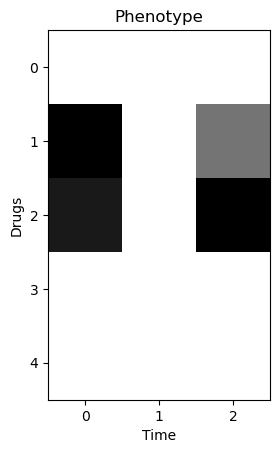

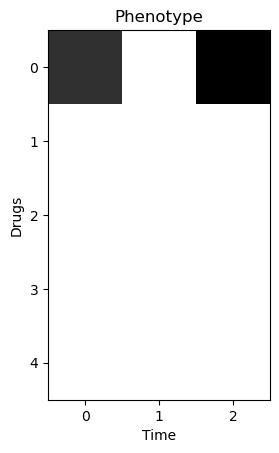

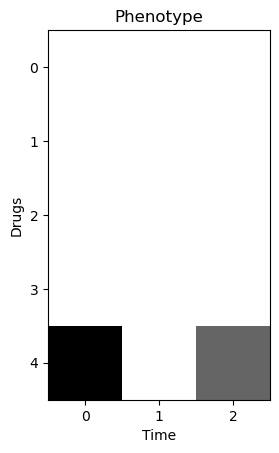

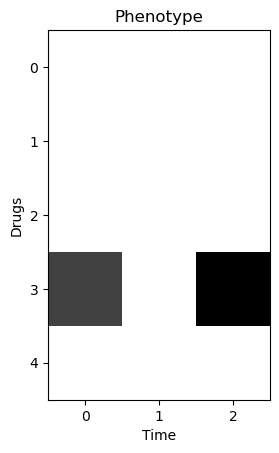

In [8]:
for i in range(params["model"]["rank"]):
    plt.imshow(Ph[i], vmin=0, vmax=1, cmap="binary",interpolation='none')
    plt.ylabel("Drugs")
    plt.xlabel("Time")
    plt.title("Phenotype")
    plt.show()

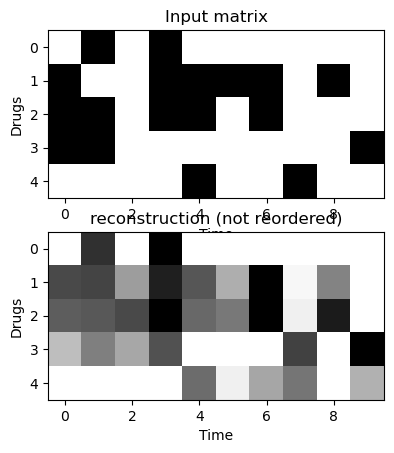

In [9]:
# make decomposition with the train model: it projects the X on the phenotypes of the model
# note that projection can be applied on new data. We use data from the training set for the sake
# of simplicity
id = 20
W = swotted(X[id, :, :].unsqueeze(0))
# Apply reconstruction
Y = swotted.model.reconstruct(W,swotted.Ph)

# Patient decomposition
plt.subplot(211)
plt.imshow(X[id].detach().numpy(), vmin=0, vmax=1, cmap="binary",interpolation='none')
plt.ylabel("Drugs")
plt.xlabel("Time")
plt.title("Input matrix")
plt.subplot(212)
plt.imshow(Y[0].detach().numpy(), vmin=0, vmax=1, cmap="binary",interpolation='none')
plt.ylabel("Drugs")
plt.xlabel("Time")
plt.title("Pathway")
plt.title("reconstruction (not reordered)")
plt.show()

In [10]:
Ph.shape

(4, 5, 3)

*Mapping of X into the Phenotype Space*

The mapping of the input tensor `X` into the phenotype space is performed using the trained SWoTTeD model. This process involves projecting the input data onto the discovered phenotypes, which allows us to represent each patient's data in terms of the identified phenotypes.

The steps involved in this mapping are as follows:

1. **Projection**: The input tensor `X` is projected onto the phenotype space using the trained SWoTTeD model. This projection is done by passing the input tensor through the model, which results in a new tensor `W`. The tensor `W` represents the weights or contributions of each phenotype for each patient over time.

2. **Reconstruction**: The projected tensor `W` can be used to reconstruct the input tensor `X` using the discovered phenotypes. This reconstruction helps in understanding how well the phenotypes capture the underlying patterns in the input data.

The following code snippet demonstrates the projection of the input tensor `X` onto the phenotype space:


In [11]:
# Project the patients onto the phenotype space
W_all = swotted(X)
W_all.shape

torch.Size([200, 4, 8])

*Reshape the Tensor for Clustering*

In the next step, we need to reshape the tensor `W_all` to prepare it for clustering. The tensor `W_all` has the shape `(K, rank, T)`, where `K` is the number of patients, `rank` is the number of phenotypes, and `T` is the length of the time window.

To perform clustering, we need to convert this 3D tensor into a 2D array where each row represents a patient and each column represents a feature. We achieve this by reshaping `W_all` to have the shape `(K, rank * T)`. This way, each patient's data is flattened into a single row, making it suitable for clustering algorithms like KMeans.

In [12]:
# Reshape W_all for clustering
W_all_reshaped = W_all.view(K, -1).detach().numpy()
W_all_reshaped.shape

(200, 32)

In [13]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(W_all_reshaped)

# Get the cluster labels
labels = kmeans.labels_

# Print the cluster labels
print(labels)

c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memor

[0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 2 2 2 0 1 1 0 0 2 1 0 1 2 1 0 0 1 1 0 0
 1 0 2 1 1 0 2 0 0 0 1 2 2 0 2 0 0 2 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 2
 0 2 1 1 2 1 0 2 0 0 1 2 0 2 0 1 0 2 2 2 0 0 1 1 2 0 0 0 2 2 2 2 0 2 0 0 2
 2 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 2 0 1 2 0 0 1 0 0 1 0 1 0 2
 2 1 0 0 0 0 1 2 2 1 2 0 2 2 1 2 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0
 0 0 0 1 2 0 0 0 0 1 0 0 0 1 0]


# VICAN

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pyreadstat
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os

import datetime
from datetime import timedelta


In [4]:
from swotted.utils import Subset, success_rate

In [ ]:
# !pip install sas7bdat
!pip install pyreadstat
!pip install xlrd
!pip install tensorly

   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.4 MB 1.1 MB/s eta 0:00:03
   ---------- ----------------------------- 0.6/2.4 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 17.1 MB/s eta 0:00:00


DEPRECATION: Loading egg at c:\users\nicolas.grevet\appdata\local\anaconda3\lib\site-packages\fonttools-4.53.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\nicolas.grevet\appdata\local\anaconda3\lib\site-packages\fqdn-1.5.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\nicolas.grevet\appdata\local\anaconda3\lib\site-packages\isoduration-20.11.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\nicolas.grevet\appdata\l

## CDV_BaseRepondants

In [5]:
folder_path0 = 'C:/Users/nicolas.grevet/Desktop/VICAN2/CDV_BaseRepondants_CB&SC_20150210'
file0 = 'CDV_BaseRepondants_CB&SC_20150210.sav'
d0, m0 = pyreadstat.read_sav(os.path.join(folder_path0, file0))

In [6]:
d0.ID_PATIENT.nunique()

4347

In [7]:
# columns = {}
# columns.update({m0.column_names[j]:m0.column_labels[j] for j in range(len(m0.column_names))})
# metadata = pd.DataFrame(columns.items(), columns=['column_name', 'column_label'])

# column_label = metadata['column_label'].values
# values_count = d0.count()
# missing_values = d0.isnull().sum()
# missing_percentage = np.round((missing_values / len(d0) * 100), 2)
# missing_summary = pd.DataFrame({
#     'Column Label': column_label,
#     'Values Count' : values_count,
#     'Missing Values': missing_values,
#     'Percentage (%)': missing_percentage,
# })

# missing_summary
# missing_summary.to_excel((os.path.join(folder_path0, 'missing_summary.xlsx')), index=True)

In [7]:
cancer_mapping = {
    1: "Sein",
    2: "Poumon",
    3: "Côlon rectum",
    4: "Prostate",
    5: "VADS",
    6: "Vessie",
    7: "Rein",
    9: "Thyroïde",
    10: "Lymphome",
    11: "Mélanome",
    81: "Col de l'utérus",
    82: "Corps de l'utérus"
}

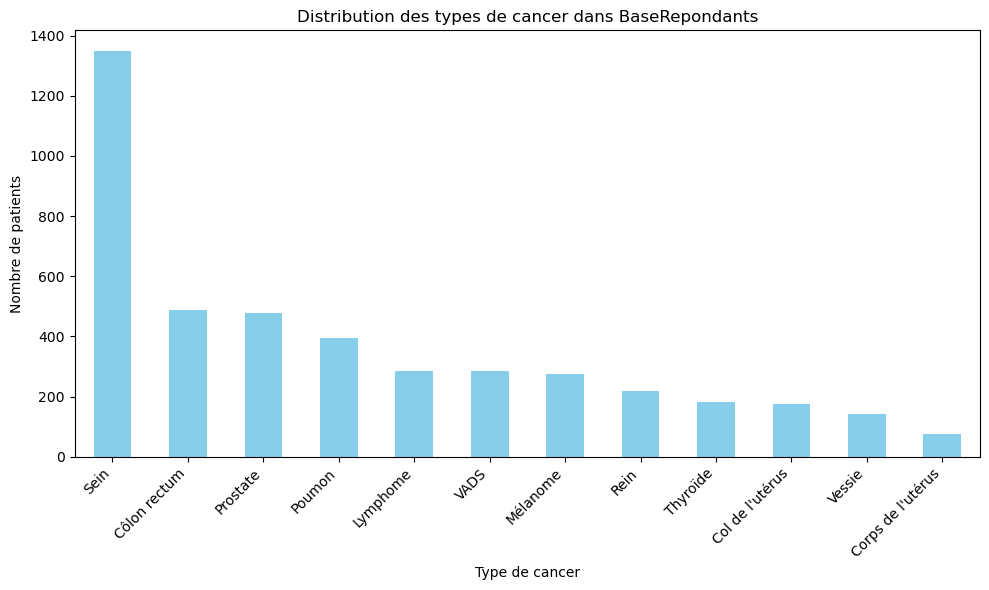

In [8]:
cancer_counts = d0.FC_CodCancer.map(cancer_mapping).value_counts()

plt.figure(figsize=(10, 6))
cancer_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Distribution des types de cancer dans BaseRepondants")
plt.xlabel("Type de cancer")
plt.ylabel("Nombre de patients")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
d0_poumon = d0[d0.FC_CodCancer == 2]
d0_colrectum = d0[d0.FC_CodCancer == 3]   

In [12]:
# df_cr_chimioradio = d0_colrectum[d0_colrectum['QM03_A14'] == 1]

## CDV_BaseEchantillon

In [9]:
CDV = pd.read_csv('C:/Users/nicolas.grevet/Desktop/VICAN2/CDV_BaseEchantillon_Nicolas.csv', sep=';')

In [10]:
CDV.ID_PATIENT.nunique()

12412

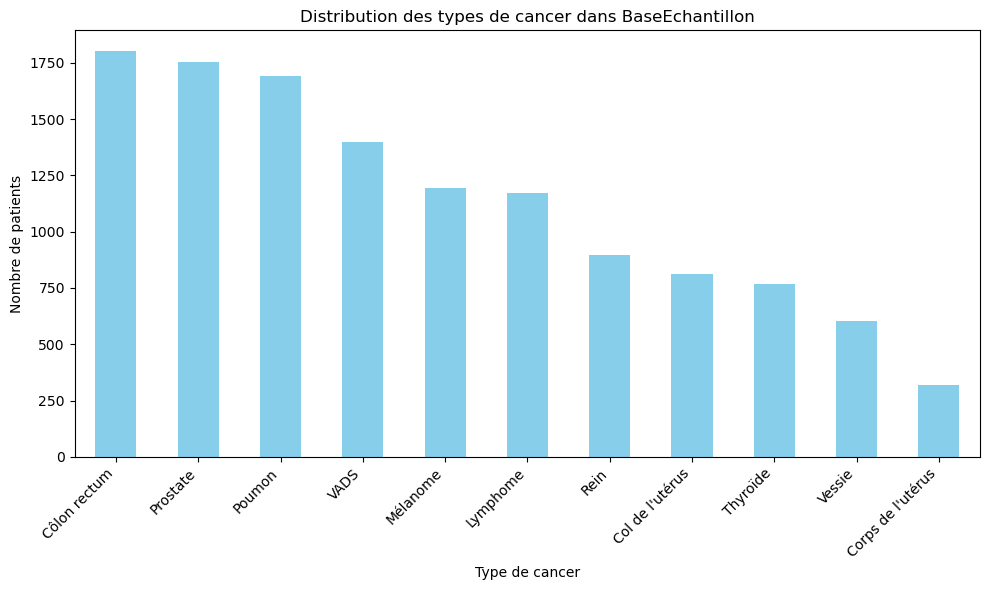

In [11]:
cancer_counts = CDV.FC_CodCancer.map(cancer_mapping).value_counts()

plt.figure(figsize=(10, 6))
cancer_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Distribution des types de cancer dans BaseEchantillon")
plt.xlabel("Type de cancer")
plt.ylabel("Nombre de patients")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
#filter to keep only the patients with FC_CodCancer = 2 ou 3 (poumon & Côlon-rectum)
CDV_poumon = CDV[CDV.FC_CodCancer == 2]
CDV_colrectum = CDV[CDV.FC_CodCancer == 3]

CDV_poumon["ID_PATIENT"] = CDV_poumon["ID_PATIENT"].astype(str)
CDV_colrectum["ID_PATIENT"] = CDV_colrectum["ID_PATIENT"].astype(str)

In [15]:
print(f"{CDV_poumon.ID_PATIENT.nunique()} patients ont un cancer du poumon dans la base Echantillon. {d0_poumon.ID_PATIENT.nunique()} dans la base Repondants ({np.round(d0_poumon.ID_PATIENT.nunique()/CDV_poumon.ID_PATIENT.nunique(), 2) *100}%)")
print(f"{CDV_colrectum.ID_PATIENT.nunique()} patients ont un cancer du côlon-rectum dans la base Echantillon. {d0_colrectum.ID_PATIENT.nunique()} dans la base Repondants ({np.round(d0_colrectum.ID_PATIENT.nunique()/CDV_colrectum.ID_PATIENT.nunique(), 2) *100}%)")
print(f"{np.round(1 - d0.ID_PATIENT.nunique()/CDV.ID_PATIENT.nunique(), 2) *100}% des patients présents dans la base Echantillon ne sont pas dans la base Repondants")

1693 patients ont un cancer du poumon dans la base Echantillon. 396 dans la base Repondants (23.0%)
1804 patients ont un cancer du côlon-rectum dans la base Echantillon. 487 dans la base Repondants (27.0%)
65.0% des patients présents dans la base Echantillon ne sont pas dans la base Repondants


In [16]:
CDV_poumon_plus = CDV_poumon.merge(d0, on='ID_PATIENT', how='inner')
CDV_poumon_plus.reset_index(drop=True, inplace=True) 

CDV_colrectum_plus = CDV_colrectum.merge(d0, on='ID_PATIENT', how='inner')
CDV_colrectum_plus.reset_index(drop=True, inplace=True) 

assert(CDV_poumon_plus.ID_PATIENT.nunique() == d0_poumon.ID_PATIENT.nunique())
assert(CDV_colrectum_plus.ID_PATIENT.nunique() == d0_colrectum.ID_PATIENT.nunique())

In [ ]:
# missing_values = CDV_colrectum_plus.isnull().sum()
# values_count = CDV_colrectum_plus.count()
# missing_percentage = np.round((missing_values / len(d0) * 100), 2)
# missing_summary = pd.DataFrame({
#     'Values Count' : values_count,
#     'Missing Values': missing_values,
#     'Percentage (%)': missing_percentage
# })

# # missing_summary
# # missing_summary.to_excel((os.path.join(folder_path0, 'missing_summary.xlsx')), index=True)

In [19]:
# CDV_poumon_plus.ID_PATIENT.unique()[:10]

#### Analyse descriptive des patients de CDV_colrectum_plus

In [29]:
cr = CDV_colrectum_plus[['ID_PATIENT', 'FC_Sexe', 'FC_AgeDiag_R0', 'FC_AgeDiag_R4', 'FC_DateNaissance', 'FC_CIM10', 'QM03_A1_R', 'CS_Evol_Metastases', 'QP_med41', 'QM03_A10', 'QM03_A11', 'QM03_A12', 'QM03_A13', 'QM03_A14']]
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_PATIENT          487 non-null    object 
 1   FC_Sexe             487 non-null    float64
 2   FC_AgeDiag_R0       487 non-null    float64
 3   FC_AgeDiag_R4       487 non-null    float64
 4   FC_DateNaissance    487 non-null    object 
 5   FC_CIM10            487 non-null    object 
 6   QM03_A1_R           432 non-null    float64
 7   CS_Evol_Metastases  487 non-null    float64
 8   QP_med41            487 non-null    float64
 9   QM03_A10            487 non-null    float64
 10  QM03_A11            487 non-null    float64
 11  QM03_A12            487 non-null    float64
 12  QM03_A13            487 non-null    float64
 13  QM03_A14            487 non-null    float64
dtypes: float64(11), object(3)
memory usage: 53.4+ KB


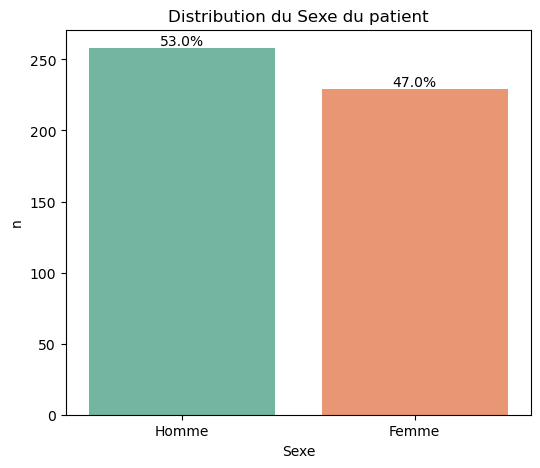

In [287]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=cr, x='FC_Sexe', palette='Set2')
plt.xticks([0, 1], ['Homme', 'Femme'])
plt.title('Distribution du Sexe du patient')
plt.xlabel('Sexe')
plt.ylabel('n')

total = len(cr)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

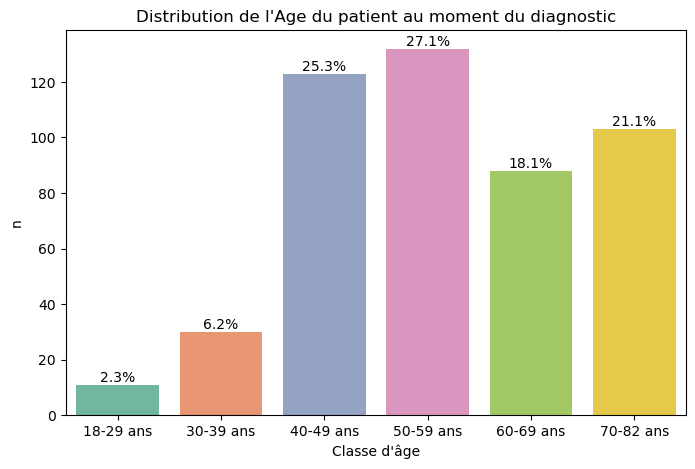

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=cr, x='FC_AgeDiag_R4', palette='Set2')
plt.xticks([0, 1, 2, 3, 4, 5], ['18-29 ans', '30-39 ans', '40-49 ans', '50-59 ans', '60-69 ans', '70-82 ans'])
plt.title('Distribution de l\'Age du patient au moment du diagnostic')
plt.xlabel('Classe d\'âge')
plt.ylabel('n')

total = len(cr)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

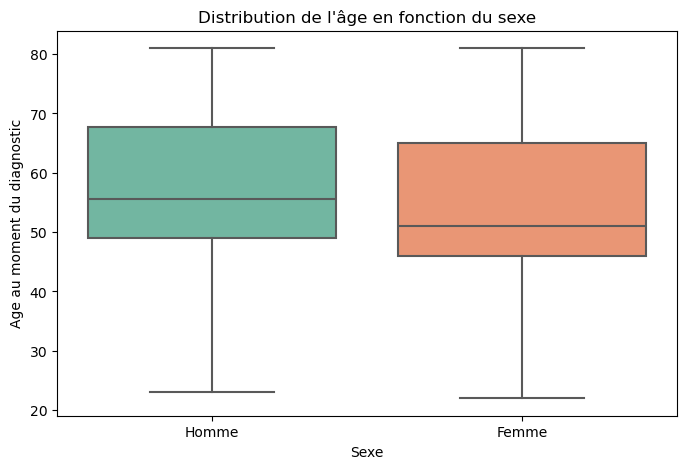

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=cr, x='FC_Sexe', y='FC_AgeDiag_R0', palette='Set2')
plt.xticks([0, 1], ['Homme', 'Femme'])
plt.title('Distribution de l\'âge en fonction du sexe')
plt.xlabel('Sexe')
plt.ylabel('Age au moment du diagnostic')
plt.show()

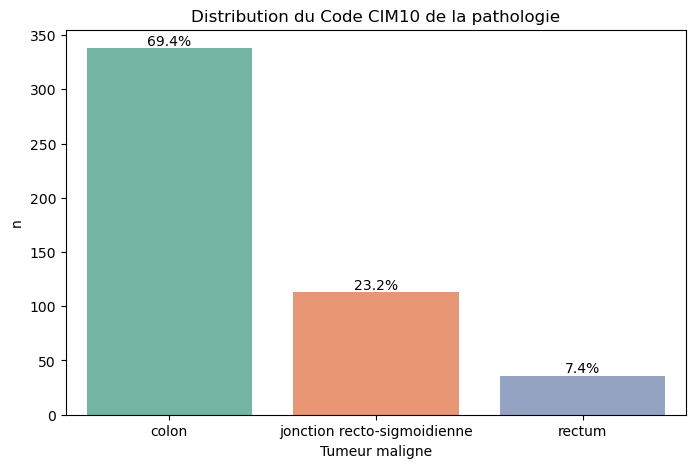

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=cr, x='FC_CIM10', palette='Set2')
plt.xticks([0, 1, 2], ['colon', 'jonction recto-sigmoidienne', 'rectum'])
plt.title('Distribution du Code CIM10 de la pathologie')
plt.xlabel('Tumeur maligne')
plt.ylabel('n')

total = len(cr)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

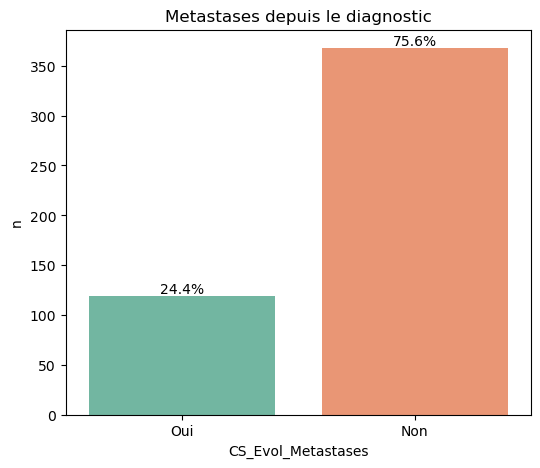

In [301]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=cr, x='CS_Evol_Metastases', palette='Set2', order=[1, 0])
plt.xticks([0, 1], ['Oui', 'Non'])
plt.title('Metastases depuis le diagnostic')
# plt.xlabel('Sexe')
plt.ylabel('n')

total = len(cr)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

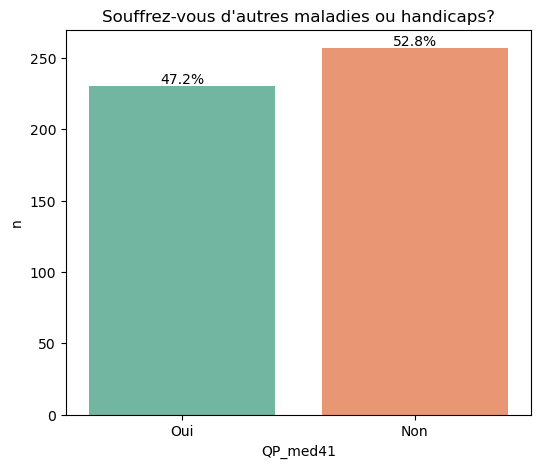

In [ ]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=cr, x='QP_med41', palette='Set2')
plt.xticks([0, 1], ['Oui', 'Non'])
plt.title('Souffrez-vous d\'autres maladies ou handicaps?')
# plt.xlabel('')
plt.ylabel('n')

total = len(cr)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

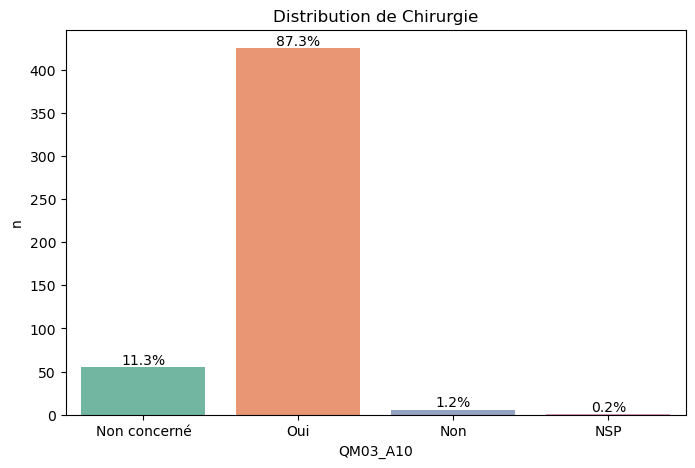

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=cr, x='QM03_A10', palette='Set2')
plt.xticks([0, 1, 2, 3], ['Non concerné', 'Oui', 'Non', 'NSP'])
plt.title('Distribution de Chirurgie')
# plt.xlabel('')
plt.ylabel('n')

total = len(cr)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

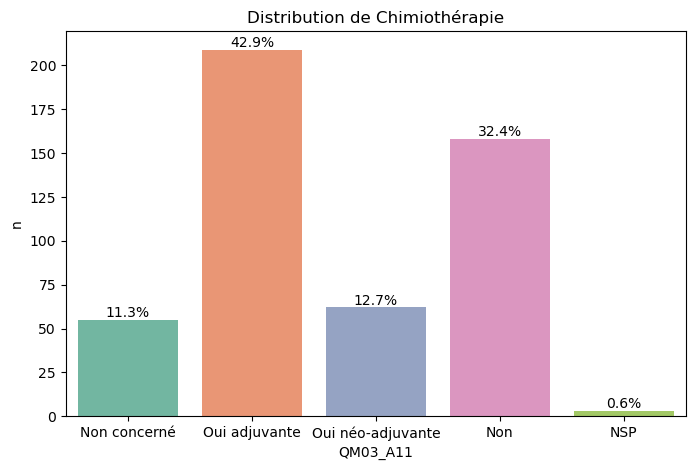

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=cr, x='QM03_A11', palette='Set2')
plt.xticks([0, 1, 2, 3, 4], ['Non concerné', 'Oui adjuvante', 'Oui néo-adjuvante', 'Non', 'NSP'])
plt.title('Distribution de Chimiothérapie')
# plt.xlabel('')
plt.ylabel('n')

total = len(cr)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

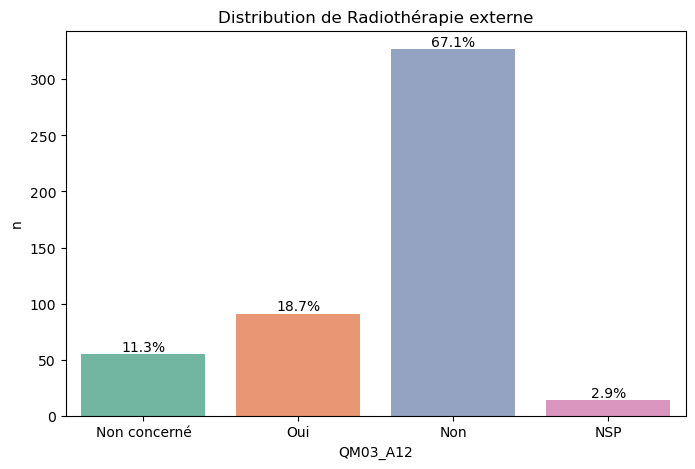

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=cr, x='QM03_A12', palette='Set2')
plt.xticks([0, 1, 2, 3], ['Non concerné', 'Oui', 'Non', 'NSP'])
plt.title('Distribution de Radiothérapie externe')
# plt.xlabel('')
plt.ylabel('n')

total = len(cr)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()


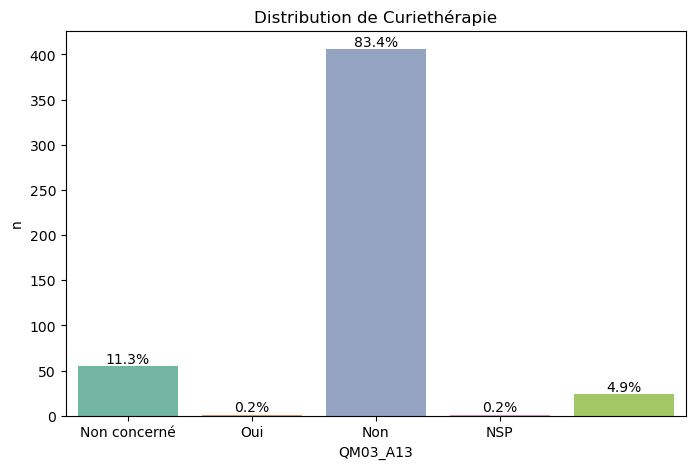

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=cr, x='QM03_A13', palette='Set2')
plt.xticks([0, 1, 2, 3], ['Non concerné', 'Oui', 'Non', 'NSP'])
plt.title('Distribution de Curiethérapie')
# plt.xlabel('')
plt.ylabel('n')

total = len(cr)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

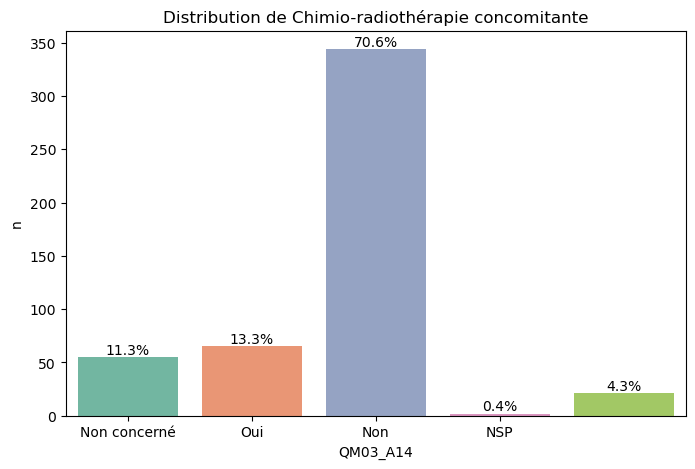

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=cr, x='QM03_A14', palette='Set2')
plt.xticks([0, 1, 2, 3], ['Non concerné', 'Oui', 'Non', 'NSP'])
plt.title('Distribution de Chimio-radiothérapie concomitante')
# plt.xlabel('')
plt.ylabel('n')

total = len(cr)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

## Conso_soins

In [17]:
# les dates sont au format numériques, calculées en temps par rapport au 01/01/1960. En recalculant par rapport à cette date, tu retombes sur les bonnes dates.
base_date = datetime.datetime(1960, 1, 1)

def convert_numeric_date(numeric_date):
    if pd.isnull(numeric_date):
        return None
    else:
        return base_date + timedelta(days=numeric_date)

In [18]:
folder_path = 'C:/Users/nicolas.grevet/Desktop/VICAN2/Conso_soins_20171006'

data_all, meta_all = [], []
for year in range(2009, 2017):
    print("\n")
    data, meta = [], []
    for file in os.listdir(folder_path):
        if file.startswith("table_"+str(year)):
            file_path = os.path.join(folder_path, file)
            d, m = pyreadstat.read_sas7bdat(file_path)
            # print(file.split('.')[0]+' : '+str(d.ID_PATIENT.nunique())+' patients')  
            data.append(d)
            meta.append(m)

    # merge all dataframes by ID_PATIENT year by year
    data_all.append(pd.concat(data).sort_values(by=['ID_PATIENT', 'DATE_PRESC']))
    meta_all.append(meta)

for i, data in enumerate(data_all):
    print(f"Data for year {2009+i} : shape {data.shape} & {data.ID_PATIENT.nunique()} patients")    

















Data for year 2009 : shape (1910842, 50) & 15739 patients
Data for year 2010 : shape (4674187, 51) & 16283 patients
Data for year 2011 : shape (2986722, 51) & 16199 patients
Data for year 2012 : shape (2642317, 51) & 16084 patients
Data for year 2013 : shape (1332867, 51) & 12847 patients
Data for year 2014 : shape (1521685, 51) & 13941 patients
Data for year 2015 : shape (1444115, 51) & 13369 patients
Data for year 2016 : shape (2436990, 51) & 12873 patients


In [19]:
#faire un dictionnaire où les column_names correspondent au column_labels de meta
columns = {}
for i in range(len(meta_all[1])):
    columns.update({meta_all[1][i].column_names[j]:meta_all[1][i].column_labels[j] for j in range(len(meta_all[1][i].column_names))})
metadata = pd.DataFrame(columns.items(), columns=['column_name', 'column_label'])
metadata  

,column_name,column_label
0,ID_PATIENT,Identifiant CDV
1,DATE_HOSPIT,Date de l'hospitalisation
2,LIB_PREST,Libellé de la prestation
3,DATE_PRESC,Date de prescription
4,DATE_DELIV,Date de délivrance
5,CODE_SPE,Code de la spécialité du prescripteur
6,LIB_SPE,Libellé de la spécialité du prescripteur
7,QUANTITE,Quantité prescrite
8,CODE_PREST,Code de la prestation
9,LIB_BIO,Libellé de l'acte biologique


#### Sanity check

In [435]:
columns_2009 = set(data_all[0].columns)
columns_2010 = set(data_all[1].columns)
columns_2011 = set(data_all[2].columns)
columns_2012 = set(data_all[3].columns)
columns_2013 = set(data_all[4].columns)
columns_2014 = set(data_all[5].columns)
columns_2015 = set(data_all[6].columns)
columns_2016 = set(data_all[7].columns)

columns_in_2010_not_in_2009 = columns_2010 - columns_2009
print(columns_in_2010_not_in_2009)

for year in range(2010, 2017):
    columns_current_year = set(data_all[year - 2009].columns)
    assert columns_current_year == columns_2010, f"Mismatch in columns for year {year}: {columns_current_year - columns_2010}"

{'UCD_COD'}


AssertionError: Mismatch in columns for year 2013: {'DELAI_ENTREE'}

In [ ]:
# for i in range(len(data_all)):
#     # convert CODE_CCAM to string
#     data_all[0]['CODE_CCAM'] = data_all[0]['CODE_CCAM'].astype(str) 
#     #   
#     if len(data_all[0][data_all[0]['CODE_CCAM'].apply(lambda x: len(x.split('-')) > 2)]) == 0: pass
#     else:
#         print(data_all[0][data_all[0]['CODE_CCAM'].apply(lambda x: len(x.split('-')) > 2)])

## Colon-Rectum

### Data preprocessing

In [20]:
data_colrectum = [df[df['ID_PATIENT'].isin(list(CDV_colrectum['ID_PATIENT'].values))] for df in data_all]
# check the number of patients in each year
for i, data in enumerate(data_colrectum):
    print(f"Data for year {2009+i} : shape {data.shape} & {data.ID_PATIENT.nunique()} patients")

Data for year 2009 : shape (205969, 50) & 1699 patients
Data for year 2010 : shape (662461, 51) & 1776 patients
Data for year 2011 : shape (389694, 51) & 1773 patients
Data for year 2012 : shape (329811, 51) & 1759 patients
Data for year 2013 : shape (168023, 51) & 1430 patients
Data for year 2014 : shape (182602, 51) & 1504 patients
Data for year 2015 : shape (161543, 51) & 1414 patients
Data for year 2016 : shape (269327, 51) & 1353 patients


In [153]:
# data_2009_colrectum1.CODE_DIAG_PRINC.value_counts()
# data_2016_colrectum1.CODE_DIAG_PRINC.value_counts()[:30]

In [21]:
data_2009_colrectum1 = data_colrectum[0].drop_duplicates()
data_2010_colrectum1 = data_colrectum[1].drop_duplicates()
data_2011_colrectum1 = data_colrectum[2].drop_duplicates()
data_2012_colrectum1 = data_colrectum[3].drop_duplicates()
data_2013_colrectum1 = data_colrectum[4].drop_duplicates()
data_2014_colrectum1 = data_colrectum[5].drop_duplicates()
data_2015_colrectum1 = data_colrectum[6].drop_duplicates()
data_2016_colrectum1 = data_colrectum[7].drop_duplicates()

df_colrectum = pd.concat([data_2009_colrectum1, data_2010_colrectum1, data_2011_colrectum1, data_2012_colrectum1, data_2013_colrectum1, data_2014_colrectum1, data_2015_colrectum1, data_2016_colrectum1], ignore_index=True)
# print(df_colrectum.ID_PATIENT.nunique())

# convert 'nan' string to NaN
df_colrectum = df_colrectum.replace('nan', np.nan)

# apply function convert_numeric_date to all columns containing 'DATE_' in their name
for col in df_colrectum.columns:
    if 'DATE_' in col:
        df_colrectum[col] = df_colrectum[col].apply(convert_numeric_date)

df_colrectum = df_colrectum.dropna(axis=1, how='all')
print(df_colrectum.ID_PATIENT.nunique())

1785


In [22]:
df_colrectum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2217038 entries, 0 to 2217037
Data columns (total 52 columns):
 #   Column           Dtype         
---  ------           -----         
 0   ID_PATIENT       object        
 1   DATE_HOSPIT      datetime64[ns]
 2   LIB_PREST        object        
 3   DATE_PRESC       datetime64[ns]
 4   DATE_DELIV       datetime64[ns]
 5   CODE_SPE         float64       
 6   LIB_SPE          object        
 7   QUANTITE         float64       
 8   CODE_PREST       object        
 9   LIB_BIO          object        
 10  CODE_BIO         object        
 11  CODE_CCAM        object        
 12  LIB_CCAM         object        
 13  ACTIVITE_CCAM    object        
 14  CODE_CAT_ETAB    float64       
 15  LIB_CAT_ETAB     object        
 16  LIB_GHS          object        
 17  STATUT_ETAB      float64       
 18  CODE_GHS         object        
 19  LIB_LPP          object        
 20  CODE_LPP         object        
 21  LIB_CIP          object        

In [26]:
# df_colrectum[df_colrectum['ID_PATIENT'].isin(list(df_cr_chimioradio['ID_PATIENT'].values))].CODE_DIAG_PRINC.value_counts()[:20]

In [27]:
# df_colrectum[df_colrectum['ID_PATIENT'].isin(list(df_cr_chimioradio['ID_PATIENT'].values))].CODE_DIAG_REL.value_counts()[:20]

In [23]:
df_colrectum.CODE_DIAG_PRINC.value_counts(dropna=False)[:50]
# df_colrectum.CODE_DIAG_REL.value_counts()
# df_colrectum.LIB_PREST.value_counts()[:30]
# df_colrectum[df_colrectum['LIB_PREST']==''].LIB_CCAM.value_counts()[:30] 
# df_colrectum.LIB_CIP.value_counts()[:20]

CODE_DIAG_PRINC
NaN       2171179
Z511        23379
Z5101        4645
Z491         1634
C20          1072
RSSABS        959
Z452          937
Z8500         565
C187          550
Z080          425
C787          343
Z515          292
C19           282
C182          276
Z5100         264
K566          208
Z432          183
Z087          170
C186          169
C183          165
C180          161
K439          140
Z433          138
C184          134
Z098          124
C780          119
D374          114
C189          110
R104          110
Z082          105
Z5130         105
K573          104
C185          102
K635+8        101
D122           93
H251           90
D125           90
D126           90
D128           86
K635           86
D123           80
D126+8         77
C786           76
Z512           74
D124           69
K624           68
K565           67
K635+0         60
C189+8         58
D120           58
Name: count, dtype: int64

In [24]:
# Filter patients with 'C18', 'C19', or 'C20' in CODE_DIAG_PRINC
filtered_patients = df_colrectum[df_colrectum['CODE_DIAG_PRINC'].isin(['C18','C180','C181','C182','C183','C184','C185','C186','C187','C188','C189','C189+8','C19','C20'])].drop_duplicates(subset=['ID_PATIENT','CODE_DIAG_PRINC'])
filtered_patients.reset_index(drop=True, inplace=True)

filtered_patients['DATE'] = filtered_patients[['DATE_PRESC', 'DATE_DELIV', 'DATE_HOSPIT', 'DATE_ENTREE', 'DATE_SORTIE']].bfill(axis=1).iloc[:, 0]

# Get the unique count of patients
num_patients = filtered_patients['ID_PATIENT'].nunique()
print(f"Nombre de patients : {num_patients}")

Nombre de patients : 1530


In [25]:
filtered_patients[['ID_PATIENT', 'CODE_DIAG_PRINC', 'DATE']].sort_values(by=['ID_PATIENT', 'DATE'])

,ID_PATIENT,CODE_DIAG_PRINC,DATE
297,1101100224,C182,2010-04-27
0,1101105979,C180,2009-12-09
298,1101106819,C20,2010-10-06
299,1101107369,C182,2010-01-15
300,1101108956,C184,2010-03-15
...,...,...,...
1929,2394100826,C186,2010-05-03
1931,2395100127,C182,2010-03-04
1933,2395100171,C187,2010-01-09
1932,2395100171,C186,2010-02-11


In [26]:
# Ajouter une colonne pour calculer les jours depuis la première occurrence pour chaque patient
filtered_patients['Days_Since_First_Events'] = filtered_patients.groupby('ID_PATIENT')['DATE'].transform(lambda x: (x - x.min()).dt.days)

# Ajouter une colonne pour calculer les mois depuis la première occurrence
filtered_patients['Months_Since_First_Events'] = filtered_patients['Days_Since_First_Events'] // 30

# Filtrer les patients ayant un changement de modalité dans 'CODE_DIAG_PRINC' au moins 3 mois après la première occurrence
patients_with_code_change = filtered_patients[
    (filtered_patients['Months_Since_First_Events'] >= 3)
].groupby('ID_PATIENT').filter(
    lambda group: group['CODE_DIAG_PRINC'].nunique() > 1
)

# Nombre de patients
num_patients_with_code_change = patients_with_code_change['ID_PATIENT'].nunique()
print(f"Nombre de patients avec un changement de modalité : {num_patients_with_code_change}")

Nombre de patients avec un changement de modalité : 15


In [27]:
patients_with_code_change[['ID_PATIENT', 'CODE_DIAG_PRINC', 'DATE', 'Months_Since_First_Events']].sort_values(by=['ID_PATIENT', 'DATE'])

,ID_PATIENT,CODE_DIAG_PRINC,DATE,Months_Since_First_Events
356,1113103543,C183,2010-06-21,8
2055,1113103543,C189,2016-02-03,76
467,1129108697,C189+8,2010-09-08,10
1936,1129108697,C189,2011-06-23,19
1938,1138105672,C184,2011-06-06,16
2046,1138105672,C182,2015-08-25,68
1939,1138109542,C187,2011-04-20,16
2033,1138109542,C189,2014-06-23,54
553,1141106078,C182,2010-05-17,3
555,1141106078,C189,2010-10-12,7


In [28]:
filtered_patients.CODE_DIAG_PRINC.value_counts(dropna=False)[:50]

CODE_DIAG_PRINC
C20       534
C187      381
C19       212
C182      206
C186      134
C180      120
C183      116
C189       95
C184       95
C185       88
C189+8     50
C188       16
C181       14
Name: count, dtype: int64

In [29]:
capecitabine_in_cip = df_colrectum['LIB_CIP'].str.contains('CAPECITABINE', case=False, na=False)
capecitabine_in_atc = df_colrectum['LIB_ATC'].str.contains('CAPECITABINE', case=False, na=False)
capecitabine_present = capecitabine_in_cip | capecitabine_in_atc
capecitabine_rows = df_colrectum[capecitabine_present]

capecitabine_rows.LIB_CIP.value_counts()[:20]

LIB_CIP
XELODA 500MG CPR 120                                  2693
XELODA 150MG CPR 60                                    884
CAPECITABINE BGA 500MG CPR 120                          16
CAPECITABINE ZEN 500MG CPR 120                           8
CAPECITABINE BIOGARAN 500MG 1 BOITE DE 120, COMPRI       7
CAPECITABINE BIOGARAN 150MG 1 BOITE DE 60, COMPRIM       4
CAPECITABINE BGA 150MG CPR 60                            3
CAPECITABINE MYL 500MG CPR 120                           2
CAPECITABINE EG 500MG CPR 120                            1
CAPECITABINE ZEN 150MG CPR 60                            1
Name: count, dtype: int64

In [30]:
capecitabine_rows.LIB_ATC.value_counts()[:20]

LIB_ATC
CAPECITABINE    3619
Name: count, dtype: int64

In [31]:
capecitabine_rows.ID_PATIENT.nunique()

390

In [32]:
# dictionnaire des CCAM créé à partir du Rapport complet IQSS CCR_version_finale_GL_4avril19 de l'INCA (https://sante.gouv.fr/IMG/pdf/cancer_colorectal_indicateurs_de_qualite_et_de_securite_des_soins_mel_20190405.pdf)
dic_cr_inca_2019 = {

    "Chirurgie": [
        "HHFA002","HHFA004","HHFA005","HHFA006","HHFA008","HHFA009","HHFA010",
        "HHFA014","HHFA017","HHFA018","HHFA021","HHFA022","HHFA023","HHFA024",
        "HHFA026","HHFA028","HHFA029","HHFA030","HHFA031","HHFC040","HHFC296",
        "HJFA001","HJFA002","HJFA003","HJFA004","HJFA005","HJFA006","HJFA007",
        "HJFA011","HJFA012","HJFA014","HJFA017","HJFA018","HJFA019","HJFC031",
        "HJFD002","HJFC023"
        ],
    "Radiothérapie": [
        "YYYY016", "YYYY021", "YYYY023", "YYYY045", "YYYY056", "YYYY080", "YYYY081",
        "YYYY099", "YYYY101", "YYYY109", "YYYY122", "YYYY128", "YYYY136", "YYYY141",
        "YYYY151", "YYYY152", "YYYY166", "YYYY175", "YYYY197", "YYYY211", "YYYY223",
        "YYYY225", "YYYY244", "YYYY256", "YYYY267", "YYYY299", "YYYY301", "YYYY307",
        "YYYY310", "YYYY312", "YYYY316", "YYYY320", "YYYY323", "YYYY327", "YYYY331",
        "YYYY334", "YYYY338", "YYYY343", "YYYY345", "YYYY349", "YYYY356", "YYYY360",
        "YYYY365", "YYYY367", "YYYY371", "YYYY377", "YYYY379", "YYYY383", "YYYY387",
        "YYYY390", "YYYY393", "YYYY398", "YYYY450", "YYYY451", "YYYY457", "YYYY460",
        "YYYY468", "YYYY471", "YYYY479", "YYYY481", "YYYY491", "YYYY493", "YYYY497",
        "YYYY500", "YYYY511", "YYYY520", "YYYY522", "YYYY533", "YYYY544", "YYYY555",
        "YYYY566", "YYYY577", "YYYY588", "YYYY599", "ZZNA002", "ZZNL001", "ZZNL028",
        "ZZNL030", "ZZNL031", "ZZNL033", "ZZNL034", "ZZNL036", "ZZNL037", "ZZNL039",
        "ZZNL040", "ZZNL042", "ZZNL043", "ZZNL045", "ZZNL046", "ZZNL048", "ZZNL055",
        "ZZNL058", "ZZNL065", "ZZNL900", "ZZNL902", "ZZNL906"
    ]
}

In [33]:
code_to_libelle = {code: key for key, codes in dic_cr_inca_2019.items() for code in codes}
df_colrectum['Lib_traitement'] = df_colrectum['CODE_CCAM'].map(code_to_libelle)
df_colrectum['Lib_traitement'].value_counts(dropna=False)

Lib_traitement
NaN              2213460
Radiothérapie       1954
Chirurgie           1624
Name: count, dtype: int64

In [34]:
# df_colrectum.loc[df_colrectum['LIB_ATC'].str.contains('CAPECITABINE', case=False, na=False), 'Lib_traitement'] = 'Chimiothérapie per os'
# df_colrectum.loc[df_colrectum['LIB_ATC'].str.contains('CAPECITABINE', case=False, na=False), 'Lib_traitement'] = 'Chimiothérapie per os'
df_colrectum.loc[capecitabine_present, 'Lib_traitement'] = 'Chimiothérapie per os'
df_colrectum.loc[df_colrectum['CODE_DIAG_PRINC']=='Z511', 'Lib_traitement'] = 'Chimiothérapie IV'
df_colrectum.loc[df_colrectum['CODE_DIAG_REL']=='Z511', 'Lib_traitement'] = 'Chimiothérapie IV'
df_colrectum.loc[df_colrectum['CODE_DIAG_PRINC']=='Z512', 'Lib_traitement'] = 'Chimiothérapie IV'
df_colrectum.loc[df_colrectum['CODE_DIAG_REL']=='Z512', 'Lib_traitement'] = 'Chimiothérapie IV'
df_colrectum.loc[df_colrectum['CODE_DIAG_PRINC']=='Z5101', 'Lib_traitement'] = 'Radiothérapie'
df_colrectum.loc[df_colrectum['CODE_DIAG_REL']=='Z5101', 'Lib_traitement'] = 'Radiothérapie'
# df_colrectum.loc[df_colrectum['LIB_PREST']=='ACTE DE CHIRURGIE CCAM', 'Lib_traitement'] = 'Chirurgie'

df_colrectum['Lib_traitement'].value_counts(dropna=False)

Lib_traitement
NaN                      2181743
Chimiothérapie IV          23453
Radiothérapie               6599
Chimiothérapie per os       3619
Chirurgie                   1624
Name: count, dtype: int64

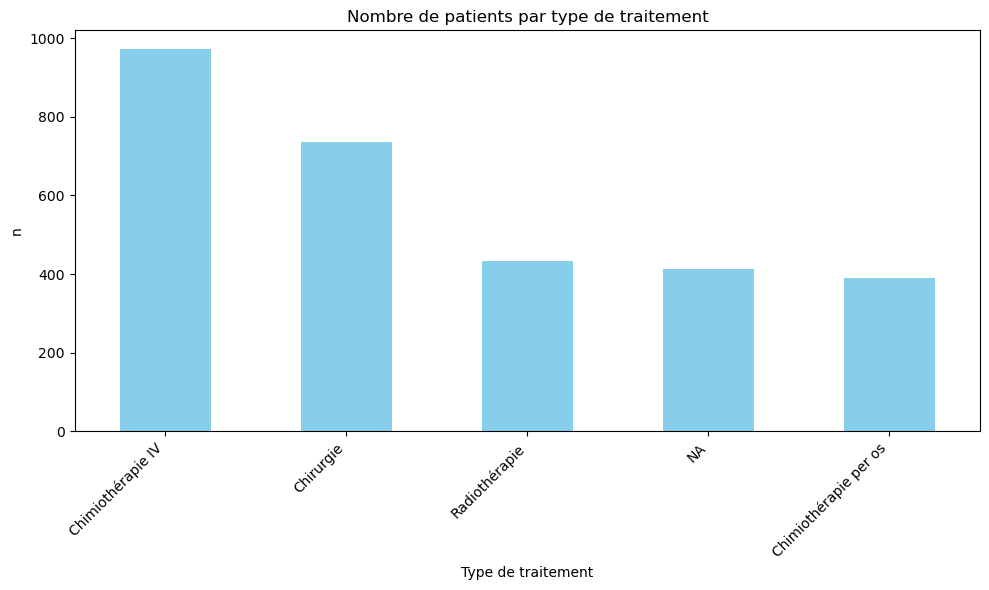

In [35]:
modalities_count = df_colrectum.groupby('Lib_traitement')['ID_PATIENT'].nunique()
all_patients = set(df_colrectum['ID_PATIENT'].unique())
treated_patients = set(df_colrectum[df_colrectum['Lib_traitement'].notna()]['ID_PATIENT'].unique())
no_treatment_patients = len(all_patients - treated_patients)

modalities_count['NA'] = no_treatment_patients

plt.figure(figsize=(10, 6))
modalities_count.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Nombre de patients par type de traitement')
plt.xlabel('Type de traitement')
plt.ylabel('n')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
df_no_treatment_patients = df_colrectum[df_colrectum['ID_PATIENT'].isin(list(all_patients - treated_patients))]
df_no_treatment_patients = df_no_treatment_patients.drop_duplicates()
# df_no_treatment_patients.CODE_DIAG_PRINC.value_counts()[:20]
df_no_treatment_patients.ID_PATIENT.nunique()

414

In [37]:
df_treatment_patients = df_colrectum[df_colrectum['ID_PATIENT'].isin(list(treated_patients))]
df_treatment_patients.drop((df_treatment_patients[~df_treatment_patients['CODE_DIAG_REL'].isin(['C18','C180','C181','C182','C183','C184','C185','C186','C187','C188','C189','C189+8','C19','C20','',np.nan])]).index, inplace=True)
df_treatment_patients.reset_index(drop=True, inplace=True)

cols_to_keep = ['ID_PATIENT', 'CODE_DIAG_PRINC', 'LIB_DIAG_PRINC', 'CODE_DIAG_REL', 'LIB_DIAG_REL', 'LIB_CCAM', 'LIB_ATC', 'Lib_traitement', 'DATE_PRESC', 'DATE_DELIV', 'DATE_HOSPIT', 'DATE_ENTREE', 'DATE_SORTIE']
df_treatment_patients = df_treatment_patients[cols_to_keep].drop_duplicates()

df_treatment_patients['DATE'] = df_treatment_patients[['DATE_PRESC', 'DATE_DELIV', 'DATE_HOSPIT', 'DATE_ENTREE', 'DATE_SORTIE']].bfill(axis=1).iloc[:, 0]

print(df_treatment_patients.ID_PATIENT.nunique())

1371


In [529]:
# modalities = df_colrectum['Libellé'].dropna().unique()
# patients_with_all_modalities = df_colrectum.groupby('ID_PATIENT').filter(
#     lambda group: set(modalities).issubset(group['Libellé'].dropna().unique())
# )

In [530]:
# patients_with_all_modalities.ID_PATIENT.nunique()

In [ ]:
# cols_to_keep = ['ID_PATIENT', 'Libellé', 'DATE_PRESC', 'DATE_DELIV', 'DATE_HOSPIT', 'DATE_ENTREE', 'DATE_SORTIE']
# patients_with_all_modalities = patients_with_all_modalities[cols_to_keep].drop_duplicates()

# patients_with_all_modalities['DATE'] = patients_with_all_modalities[['DATE_PRESC', 'DATE_DELIV', 'DATE_HOSPIT', 'DATE_ENTREE', 'DATE_SORTIE']].bfill(axis=1).iloc[:, 0]

# cols_to_keep = ['ID_PATIENT', 'Libellé', 'DATE']
# patients_with_all_modalities[patients_with_all_modalities['ID_PATIENT']=='1102101064'][cols_to_keep].dropna(subset=['Libellé']).sort_values(by=['DATE']).reset_index(drop=True)

In [38]:
df_treatment_patients_copy = df_treatment_patients.copy().dropna(subset=['Lib_traitement'])
df_treatment_patients_copy = df_treatment_patients_copy[
    (df_treatment_patients_copy['DATE'] >= '2009-01-01') & 
    (df_treatment_patients_copy['DATE'] <= '2016-12-31')
]

grouped = df_treatment_patients_copy.groupby('ID_PATIENT')

results = []
for patient_id, group in grouped:
    group = group.sort_values(by='DATE')  # Ensure the data is sorted by date
    first_date = group['DATE'].min()
    group['Days_Since_First_Events'] = (group['DATE'] - first_date).dt.days
    group['Weeks_Since_First_Events'] = group['Days_Since_First_Events'] // 7
    group['Months_Since_First_Events'] = group['Days_Since_First_Events'] // 30
    group['Days_Between_Events'] = group['Days_Since_First_Events'].diff().fillna(0).astype(int)
    group['Weeks_Between_Events'] = group['Days_Between_Events'] // 7
    group['Months_Between_Events'] = group['Days_Between_Events'] // 30

    results.append(group)

df_treatment_patients_updated = pd.concat(results)

cols_to_keep = ['ID_PATIENT', 'CODE_DIAG_PRINC', 'LIB_DIAG_PRINC', 'CODE_DIAG_REL', 'LIB_DIAG_REL', 'LIB_CCAM', 'LIB_ATC', 'Lib_traitement', 'DATE', 'Days_Since_First_Events', 'Days_Between_Events', 'Weeks_Since_First_Events', 'Weeks_Between_Events', 'Months_Since_First_Events', 'Months_Between_Events']
df_treatment_patients_updated['LIB_DIAG_PRINC'] = df_treatment_patients_updated['LIB_DIAG_PRINC'].replace("Z511", "Séance de chimiothérapie pour tumeur")
df_treatment_patients_updated['LIB_DIAG_PRINC'] = df_treatment_patients_updated['LIB_DIAG_PRINC'].replace("Séance\xa0de\xa0chimiothérapie\xa0pour\xa0tumeur", "Séance de chimiothérapie pour tumeur")
df_treatment_patients_updated['LIB_DIAG_PRINC'] = df_treatment_patients_updated['LIB_DIAG_PRINC'].replace("Z5101", "Séance d'irradiation")
df_treatment_patients_updated['LIB_DIAG_PRINC'] = df_treatment_patients_updated['LIB_DIAG_PRINC'].replace("Séance\xa0d'irradiation", "Séance d'irradiation")
df_treatment_patients_updated['LIB_DIAG_PRINC'] = df_treatment_patients_updated['LIB_DIAG_PRINC'].replace("Z512", "Autres formes de chimiothérapie")
df_treatment_patients_updated['LIB_DIAG_PRINC'] = df_treatment_patients_updated['LIB_DIAG_PRINC'].replace("Autres\xa0formes\xa0de\xa0chimiothérapie", "Autres formes de chimiothérapie")
df_treatment_patients_updated['LIB'] = df_treatment_patients_updated[['LIB_DIAG_PRINC', 'LIB_CCAM', 'LIB_ATC']].bfill(axis=1).iloc[:, 0]

df_treatment_patients_updated = df_treatment_patients_updated[cols_to_keep]
df_treatment_patients_updated.drop_duplicates(inplace=True)

In [39]:
df_treatment_patients_updated.ID_PATIENT.nunique()

1336

In [ ]:
# df_treatment_patients_updated['CODE_CIM_10'] = df_treatment_patients_updated['CODE_DIAG_REL'].str[:3]
# df_treatment_patients_updated['CODE_CIM_10'].value_counts()

In [40]:
df_treatment_patients_updated = df_treatment_patients_updated[df_treatment_patients_updated['Months_Between_Events'] <= 5]
df_treatment_patients_updated.reset_index(drop=True, inplace=True)
print(df_treatment_patients_updated.ID_PATIENT.nunique())

1336


In [ ]:
# filtered_patients = df_treatment_patients_updated[df_treatment_patients_updated['Months_Since_First_Events'] <= 23]
# print(filtered_patients.ID_PATIENT.nunique())

In [41]:
filtered_treatment_patients = df_treatment_patients_updated[
    (df_treatment_patients_updated['Months_Since_First_Events'] <= 23) & 
    (df_treatment_patients_updated['Months_Between_Events'] <= 5)
]

filtered_patients_24months = filtered_treatment_patients.groupby('ID_PATIENT').filter(
    lambda group: group['Months_Since_First_Events'].max() <= 24
)
filtered_treatment_patients.reset_index(drop=True, inplace=True)
# df_treatment_patients_updated = df_treatment_patients_updated[df_treatment_patients_updated['ID_PATIENT'].isin(filtered_patients_24months.groups.keys())]
print(filtered_treatment_patients.ID_PATIENT.nunique())

1336


In [ ]:
# df_treatment_patients_updated = df_treatment_patients_updated[df_treatment_patients_updated['Months_Between_Events'] <= 5]
# df_treatment_patients_updated.reset_index(drop=True, inplace=True)
# print(df_treatment_patients_updated.ID_PATIENT.nunique())

In [42]:
filtered_treatment_patients.head()

,ID_PATIENT,CODE_DIAG_PRINC,LIB_DIAG_PRINC,CODE_DIAG_REL,LIB_DIAG_REL,LIB_CCAM,LIB_ATC,Lib_traitement,DATE,Days_Since_First_Events,Days_Between_Events,Weeks_Since_First_Events,Weeks_Between_Events,Months_Since_First_Events,Months_Between_Events
0,1101100224,NaN,NaN,NaN,NaN,Colectomie droite avec retablissement de la co...,NaN,Chirurgie,2010-04-01,0,0,0,0,0,0
1,1101100224,Z511,Séance de chimiothérapie pour tumeur,C189,"Tumeur maligne du câlon, sans précision",NaN,NaN,Chimiothérapie IV,2010-05-10,39,39,5,5,1,1
2,1101100224,Z511,Séance de chimiothérapie pour tumeur,C182,Tumeur maligne du câlon ascendant,NaN,NaN,Chimiothérapie IV,2010-05-27,56,17,8,2,1,0
3,1101100224,Z511,Séance de chimiothérapie pour tumeur,C182,Tumeur maligne du câlon ascendant,NaN,NaN,Chimiothérapie IV,2010-06-17,77,21,11,3,2,0
4,1101100224,Z511,Séance de chimiothérapie pour tumeur,C182,Tumeur maligne du câlon ascendant,NaN,NaN,Chimiothérapie IV,2010-07-01,91,14,13,2,3,0


### Préparation dataset unidimensionnel pour TCA

In [246]:
df_unidim = df_treatment_patients_updated.sort_values(by=['ID_PATIENT', 'Months_Since_First_Events', 'DATE']).drop_duplicates(subset=['ID_PATIENT', 'Months_Since_First_Events'])
df_unidim = df_unidim[['ID_PATIENT', 'DATE', 'Months_Since_First_Events', 'Lib_traitement']].sort_values(by=['ID_PATIENT', 'DATE']).reset_index(drop=True)

In [250]:
df_unidim.to_excel('C:/Users/nicolas.grevet/Desktop/VICAN2/df_unidim_TCA.xlsx', index=False)

In [247]:
df_unidim.ID_PATIENT.nunique()  

1371

In [251]:
df_unidim_6months = df_unidim[df_unidim['Months_Since_First_Events'] <= 6]
df_unidim_6months.ID_PATIENT.nunique()  

1371

In [252]:
df_unidim_6months.to_excel('C:/Users/nicolas.grevet/Desktop/VICAN2/vican_unidim_6months_TCA.xlsx', index=False)

In [248]:
# Sélectionner les colonnes pertinentes pour l'analyse
selected_cols = df_unidim[['ID_PATIENT', 'Months_Since_First_Events', 'Lib_traitement']]
# Créer un tableau croisé des données en format large
#       -> Chaque individu est sur une ligne.
#       -> Les mesures dans le temps (Temps1, Temps2, Temps3) sont des colonnes distinctes.
pivoted_data = selected_cols.pivot(index='ID_PATIENT', columns='Months_Since_First_Events', values='Lib_traitement')
pivoted_data['id'] = pivoted_data.index
pivoted_data = pivoted_data[['id'] + [col for col in pivoted_data.columns if col != 'id']]
# Renommer les colonnes avec un préfixe "month_"
pivoted_data.columns = ['id'] + ['month_' + str(int(col)+1) for col in pivoted_data.columns[1:]]
# Sélectionner un échantillon aléatoire de 10% des données
pivoted_data_random_sample = pivoted_data.sample(frac=0.1, random_state=42).reset_index(drop=True)
pivoted_data_random_sample.head()

,id,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,month_80,month_81,month_82,month_83,month_84,month_85,month_86,month_87,month_88,month_89
0,1175105527,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1194105117,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1157104430,Chimiothérapie per os,Radiothérapie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1133108431,Chirurgie,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,Chimiothérapie IV,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1144104092,Chirurgie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analyse délais entre traitements

#### Changements de codes dans la colonne 'CODE_DIAG_REL' par patient après 3 mois

In [138]:
df_code_diag = df_treatment_patients_updated[df_treatment_patients_updated['CODE_DIAG_PRINC'].notna()]

# Filter to ensure the change happens 3 months after the last occurrence
patients_with_changes = df_code_diag[
    df_code_diag['Months_Between_Events'] >= 3
]

# Filter patients with a change in "CODE_DIAG_REL" 3 months after the last occurrence
patients_with_changes = patients_with_changes.groupby('ID_PATIENT').filter(
    lambda group: group.sort_values('Months_Between_Events')['CODE_CIM_10'].nunique() > 1
)

print(patients_with_changes['ID_PATIENT'].nunique())

55


In [139]:
patients_with_changes[['ID_PATIENT', 'CODE_DIAG_PRINC', 'CODE_DIAG_REL', 'CODE_CIM_10', 'DATE', 'Months_Between_Events']].drop_duplicates().sort_values(by=['ID_PATIENT', 'DATE']).reset_index(drop=True)

,ID_PATIENT,CODE_DIAG_PRINC,CODE_DIAG_REL,CODE_CIM_10,DATE,Months_Between_Events
0,1106106824,Z511,C20,C20,2010-12-08,3
1,1106106824,Z511,C20,C20,2011-09-12,3
2,1106106824,Z511,C189,C18,2012-10-03,5
3,1108100943,Z511,C787,C78,2011-04-06,4
4,1108100943,Z511,C787,C78,2012-04-16,10
...,...,...,...,...,...,...
166,2359102052,Z511,C20,C20,2012-06-28,15
167,2359102052,Z511,C786,C78,2014-01-30,11
168,2364100187,Z511,D012,D01,2010-12-29,7
169,2364100187,Z511,C20,C20,2013-06-14,3


In [140]:
patients_with_changes.ID_PATIENT.unique()

array(['1106106824', '1108100943', '1113108058', '1127110356',
       '1129100356', '1129105755', '1129108697', '1133104906',
       '1134203957', '1138105672', '1159403257', '1159505211',
       '1165105448', '1176301012', '1177100300', '1189108109',
       '1192100309', '1192102102', '1194105363', '1194108232',
       '1207400030', '1207500498', '1335100677', '1344100865',
       '1362101092', '1392100957', '2110103896', '2119101519',
       '2121100247', '2121103687', '2126100862', '2130100495',
       '2131101578', '2133101447', '2141102197', '2157100230',
       '2158101798', '2159400076', '2159901245', '2166102031',
       '2166103152', '2167304442', '2169104059', '2176402601',
       '2179102724', '2183103913', '2191101781', '2202900392',
       '2204900657', '2208100070', '2327100573', '2330100639',
       '2336100672', '2359102052', '2364100187'], dtype=object)

In [142]:
patients_with_changes[patients_with_changes.ID_PATIENT=='1335100677'][['ID_PATIENT', 'CODE_DIAG_PRINC', 'CODE_DIAG_REL', 'CODE_CIM_10', 'DATE', 'Months_Between_Events']]


,ID_PATIENT,CODE_DIAG_PRINC,CODE_DIAG_REL,CODE_CIM_10,DATE,Months_Between_Events
16688,1335100677,Z511,C787,C78,2011-05-09,4
16693,1335100677,Z511,C787,C78,2011-10-17,3
16733,1335100677,Z511,C20,C20,2015-06-03,3


In [ ]:
# df_treatment_patients_updated[df_treatment_patients_updated.ID_PATIENT=="1335100677"][['ID_PATIENT', 'CODE_DIAG_PRINC', 'CODE_DIAG_REL', 'CODE_CIM_10', 'DATE', 'Months_Between_Events']].to_excel('C:/Users/nicolas.grevet/Desktop/VICAN2/1335100677.xlsx', index=False)
# # 

#### 3 mois entre les événements thérapeutiques

In [117]:
test_3months = df_treatment_patients_updated[df_treatment_patients_updated['Months_Between_Events'] >= 3]
print(test_3months.ID_PATIENT.nunique())

# test_3months.CODE_DIAG_PRINC.value_counts(dropna=False)
# test_3months.CODE_DIAG_REL.value_counts(dropna=False)
# test_3months.LIB_DIAG_PRINC.value_counts()
test_3months.LIB.value_counts()[:15]

# plt.figure(figsize=(12, 6))
# bins = range(0, int(test_3months['Months_Between_Events'].max()) + 2, 2) 
# plt.hist(test_3months['Months_Between_Events'], bins=30, color='skyblue', edgecolor='black')
# plt.title('Histogram of Months Between Events')
# plt.xlabel('Months Between Events')
# plt.ylabel('Frequency')
# plt.xticks(bins) 
# plt.grid(axis='y', alpha=0.75)
# plt.show()

490


LIB
Séance de chimiothérapie pour tumeur                                                                                                                 727
CAPECITABINE                                                                                                                                         107
Séance d'irradiation                                                                                                                                  29
Supplement pour parametrage d'un collimateur multilames                                                                                               21
Autres formes de chimiothérapie                                                                                                                       15
Resection rectosigmoidienne par coelioscopie ou par laparotomie avec preparation par coelioscopie, avec anastomose coloanale par voie anale            6
Resection rectosigmoidienne avec anastomose colorectale infraperitoneale, par 

In [118]:
test_3months_unique = test_3months.drop_duplicates(subset=['ID_PATIENT', 'LIB'])
test_3months_unique.LIB.value_counts()[:15]

LIB
Séance de chimiothérapie pour tumeur                                                                                                                 403
CAPECITABINE                                                                                                                                          73
Séance d'irradiation                                                                                                                                  28
Supplement pour parametrage d'un collimateur multilames                                                                                               21
Autres formes de chimiothérapie                                                                                                                        7
Resection rectosigmoidienne par coelioscopie ou par laparotomie avec preparation par coelioscopie, avec anastomose coloanale par voie anale            6
Resection rectosigmoidienne avec anastomose colorectale infraperitoneale, par 

#### 6 mois entre les événements thérapeutiques

In [120]:
test_6months = df_treatment_patients_updated[df_treatment_patients_updated['Months_Between_Events'] >= 6]
print(test_6months.ID_PATIENT.nunique())

test_6months.LIB.value_counts()[:15]

336


LIB
Séance de chimiothérapie pour tumeur                                                                                                                       359
CAPECITABINE                                                                                                                                                47
Séance d'irradiation                                                                                                                                        20
Supplement pour parametrage d'un collimateur multilames                                                                                                     14
Autres formes de chimiothérapie                                                                                                                              9
Resection rectosigmoidienne avec anastomose colorectale infraperitoneale, par laparotomie                                                                    3
Resection rectosigmoidienne par coelioscop

#### 9 mois entre les événements thérapeutiques

In [128]:
test_9months = df_treatment_patients_updated[df_treatment_patients_updated['Months_Between_Events'] >= 9]
print(test_9months.ID_PATIENT.nunique())

test_9months.LIB.value_counts()[:15]

272


LIB
Séance de chimiothérapie pour tumeur                                                                                                                 242
CAPECITABINE                                                                                                                                          27
Séance d'irradiation                                                                                                                                  17
Supplement pour parametrage d'un collimateur multilames                                                                                               11
Autres formes de chimiothérapie                                                                                                                        6
Resection rectosigmoidienne par coelioscopie ou par laparotomie avec preparation par coelioscopie, avec anastomose coloanale par voie anale            3
Colectomie transverse, par laparotomie                                        

#### 12 mois entre les événements thérapeutiques

In [127]:
test_12months = df_treatment_patients_updated[df_treatment_patients_updated['Months_Between_Events'] >= 12]
print(test_12months.ID_PATIENT.nunique())

test_12months.LIB.value_counts()[:15]

226


LIB
Séance de chimiothérapie pour tumeur                                                                                                                 186
CAPECITABINE                                                                                                                                          24
Séance d'irradiation                                                                                                                                  15
Supplement pour parametrage d'un collimateur multilames                                                                                                8
Autres formes de chimiothérapie                                                                                                                        6
Resection rectosigmoidienne par coelioscopie ou par laparotomie avec preparation par coelioscopie, avec anastomose coloanale par voie anale            3
Resection rectosigmoidienne avec anastomose colorectale infraperitoneale, par 

#### 24 mois entre les événements thérapeutiques

In [126]:
test_24months = df_treatment_patients_updated[df_treatment_patients_updated['Months_Between_Events'] >= 24]
print(test_24months.ID_PATIENT.nunique())

test_24months.LIB.value_counts()[:15]

115


LIB
Séance de chimiothérapie pour tumeur                                                                                                                       76
Séance d'irradiation                                                                                                                                       11
CAPECITABINE                                                                                                                                               11
Supplement pour parametrage d'un collimateur multilames                                                                                                     4
Autres formes de chimiothérapie                                                                                                                             4
Amputation du rectum, par coelioscopie ou par laparotomie avec preparation par coelioscopie et par abord perineal                                           1
Supplement pour controles balistiques de qualite

#### Délais

In [453]:
stat1 = df_treatment_patients_updated.groupby('ID_PATIENT').agg({
    'Days_Between_Events': ['min', 'max', 'median', 'mean', 'std'],
    'Days_Since_First_Events': ['min', 'max', 'median', 'mean', 'std'],
    'Weeks_Since_First_Events': ['min', 'max', 'median', 'mean', 'std'],
    'Weeks_Between_Events': ['min', 'max', 'median', 'mean', 'std'],
    'Months_Since_First_Events': ['min', 'max', 'median', 'mean', 'std'],
    'Months_Between_Events': ['min', 'max', 'median', 'mean', 'std']

}).round(0)#.to_excel((os.path.join(folder_path0, 'describe2.xlsx')), index=True)

stat1.loc['median'] = stat1.median()
stat1.loc['mean'] = stat1.mean()
stat1.loc['std'] = stat1.std()

stat1.round(0)#.to_excel((os.path.join(folder_path0, 'describe3.xlsx')), index=True)

Days_Between_Events                              \
                           min    max median   mean    std   
ID_PATIENT                                                   
1101100224                 0.0  756.0   14.0   28.0   83.0   
1101105979                 0.0   45.0   14.0   14.0   10.0   
1101106819                 0.0  100.0   14.0   13.0   18.0   
1101107369                 0.0  188.0   14.0   27.0   41.0   
1101108956                 0.0  954.0   15.0  100.0  223.0   
...                        ...    ...    ...    ...    ...   
2395100318                 0.0  331.0    7.0   45.0  107.0   
2395100481                 0.0    0.0    0.0    0.0    NaN   
median                     0.0  450.0   14.0   47.0  154.0   
mean                       0.0  645.0   69.0  131.0  243.0   
std                        0.0  624.0  163.0  190.0  282.0   

           Days_Since_First_Events                                 ...  \
                               min     max  median    mean    std  ...   
ID_PATIENT                                                         ...   
1101100224                     0.0  2342.0  1624.0  1456.0  687.0  ...   
1101105979                     0.0   202.0   111.0   107.0   65.0  ...   
1101106819                     0.0   854.0   222.0   299.0  281.0  ...   
1101107369                     0.0  1041.0   608.0   562.0  360.0  ...   
1101108956                     0.0  2093.0   178.0   670.0  830.0  ...   
...                            ...     ...     ...     ...    ...  ...   
2395100318                     0.0   402.0   358.0   322.0  123.0  ...   
2395100481                     0.0     0.0     0.0     0.0    NaN  ...   
median                         0.0  1154.0   172.0   322.0  402.0  ...   
mean                           0.0  1183.0   386.0   444.0  459.0  ...   
std                            0.0   865.0   473.0   404.0  337.0  ...   

           Months_Since_First_Events                           \
                                 min   max median  mean   std   
ID_PATIENT                                                      
1101100224                       0.0  78.0   54.0  48.0  23.0   
1101105979                       0.0   6.0    3.0   3.0   2.0   
1101106819                       0.0  28.0    7.0   9.0   9.0   
1101107369                       0.0  34.0   20.0  18.0  12.0   
1101108956                       0.0  69.0    5.0  22.0  28.0   
...                              ...   ...    ...   ...   ...   
2395100318                       0.0  13.0   11.0  10.0   4.0   
2395100481                       0.0   0.0    0.0   0.0   NaN   
median                           0.0  38.0    5.0  10.0  13.0   
mean                             0.0  39.0   12.0  14.0  15.0   
std                              0.0  29.0   16.0  13.0  11.0   

           Months_Between_Events                         
                             min   max median mean  std  
ID_PATIENT                                               
1101100224                   0.0  25.0    0.0  0.0  3.0  
1101105979                   0.0   1.0    0.0  0.0  0.0  
1101106819                   0.0   3.0    0.0  0.0  0.0  
1101107369                   0.0   6.0    0.0  0.0  1.0  
1101108956                   0.0  31.0    0.0  3.0  7.0  
...                          ...   ...    ...  ...  ...  
2395100318                   0.0  11.0    0.0  1.0  4.0  
2395100481                   0.0   0.0    0.0  0.0  NaN  
median                       0.0  15.0    0.0  1.0  5.0  
mean                         0.0  21.0    2.0  4.0  8.0  
std                          0.0  21.0    5.0  6.0  9.0  

[1643 rows x 30 columns]

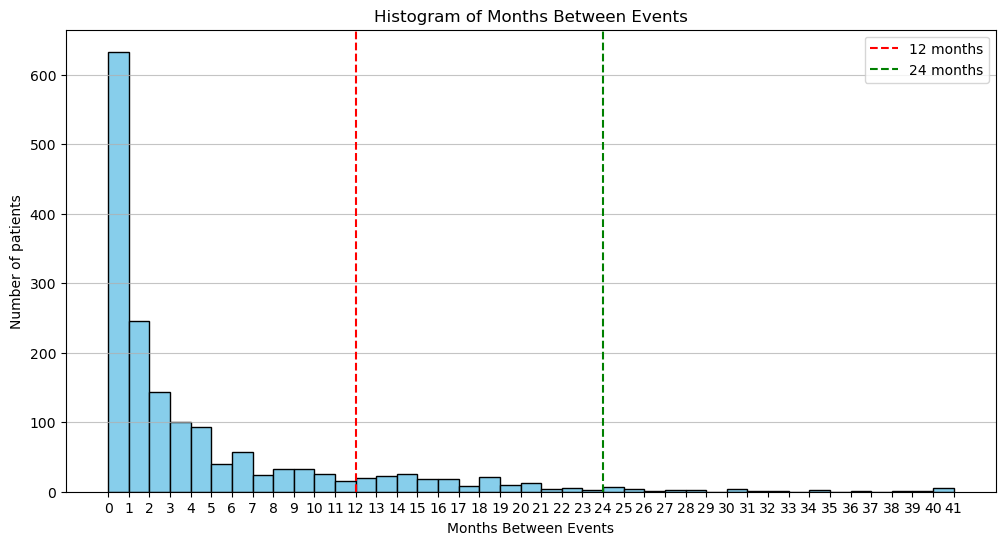

In [461]:
plt.figure(figsize=(12, 6))
bins = range(0, int(stat1[('Months_Between_Events', 'mean')].max()) + 2) 
plt.hist(stat1[('Months_Between_Events', 'mean')], bins=bins, color='skyblue', edgecolor='black')
plt.axvline(x=12, color='red', linestyle='--', label='12 months')
plt.axvline(x=24, color='green', linestyle='--', label='24 months')
plt.title('Histogram of Months Between Events')
plt.xlabel('Months Between Events')
plt.ylabel('Number of patients')
plt.xticks(bins) 
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

In [ ]:
# plt.figure(figsize=(9, 7))
# sns.kdeplot(data=stat1[('Days_Between_Events', 'median')], fill=True, color='skyblue', clip=(0, None))
# sns.kdeplot(data=stat1[('Days_Between_Events', 'mean')], fill=True, color='green', clip=(0, None))
# plt.title('KDE Plot of Days Between Events')
# plt.xlabel('Days Between Events')
# plt.ylabel('Density')
# plt.legend(['Median', 'Mean'])
# plt.show()

In [ ]:
# plt.figure(figsize=(9, 7))
# sns.kdeplot(data=stat1[stat1[('Days_Between_Events', 'median')]<90][('Days_Between_Events', 'median')], fill=True, color='skyblue', clip=(0, None))
# sns.kdeplot(data=stat1[stat1[('Days_Between_Events', 'mean')]<90][('Days_Between_Events', 'mean')], fill=True, color='green', clip=(0, None))
# plt.title('KDE Plot of Days Between Events (<90)')
# plt.xlabel('Days Between Events')
# plt.ylabel('Density')
# plt.legend(['Median', 'Mean'])
# plt.show()

In [ ]:
# df_treatment_patients_updated[df_treatment_patients_updated['ID_PATIENT']=='1101100224'].sort_values(by=['DATE']).reset_index(drop=True).to_excel((os.path.join(folder_path0, '1101100224.xlsx')), index=True)

In [ ]:
# value_counts = df_treatment_patients_updated.Libellé.value_counts()
# percentages = ((value_counts / value_counts.sum()) * 100).round(2)

# result_df1 = pd.DataFrame({
#     'Traitement': value_counts.index,
#     'Count': value_counts.values,
#     'Percentage (%)': percentages.values
# })
# result_df1
# # result_df1.to_excel((os.path.join(folder_path0, 'results2.xlsx')), index=False)

In [ ]:
# value_counts = df_treatment_patients_updated[df_treatment_patients_updated['Days_Since_First_Events'] == 0].Libellé.value_counts()
# percentages = ((value_counts / value_counts.sum()) * 100).round(2)

# result_df1 = pd.DataFrame({
#     '1er traitement': value_counts.index,
#     'Count': value_counts.values,
#     'Percentage (%)': percentages.values
# })
# result_df1
# # result_df1.to_excel((os.path.join(folder_path0, 'results1.xlsx')), index=False)

#### Patients avec plusieurs actes le premier jour 

In [ ]:
filtered_df = df_treatment_patients_updated[df_treatment_patients_updated['Days_Since_First_Events'] == 0]
multiple_rows_patients = filtered_df.groupby('ID_PATIENT').filter(lambda x: len(x) > 1)

multiple_rows_patients.ID_PATIENT.nunique() 

132

In [ ]:
# Filter patients who have both 'Chimiothérapie IV' and 'Radiothérapie'
patients_with_both0 = multiple_rows_patients.groupby('ID_PATIENT').filter(
    lambda group: {'Chimiothérapie IV', 'Chimiothérapie per os'}.issubset(group['Libellé'].unique())
)

patients_with_both1 = multiple_rows_patients.groupby('ID_PATIENT').filter(
    lambda group: {'Chimiothérapie IV', 'Radiothérapie'}.issubset(group['Libellé'].unique())
)
# patients_with_both1_1 = multiple_rows_patients.groupby('ID_PATIENT').filter(
#     lambda group: {'Radiothérapie', 'Chimiothérapie IV'}.issubset(group['Libellé'].unique())
# )

patients_with_both2 = multiple_rows_patients.groupby('ID_PATIENT').filter(
    lambda group: {'Chimiothérapie per os', 'Radiothérapie'}.issubset(group['Libellé'].unique())
)
# patients_with_both2_1 = multiple_rows_patients.groupby('ID_PATIENT').filter(
#     lambda group: {'Radiothérapie','Chimiothérapie per os'}.issubset(group['Libellé'].unique())
# )

patients_with_both3 = multiple_rows_patients.groupby('ID_PATIENT').filter(
    lambda group: {'Chirurgie', 'Radiothérapie'}.issubset(group['Libellé'].unique())
)
# patients_with_both3_1 = multiple_rows_patients.groupby('ID_PATIENT').filter(
#     lambda group: {'Radiothérapie', 'Chirurgie'}.issubset(group['Libellé'].unique())
# )

patients_with_both4 = multiple_rows_patients.groupby('ID_PATIENT').filter(
    lambda group: {'Chirurgie', 'Chimiothérapie IV'}.issubset(group['Libellé'].unique())
)

patients_with_both5 = multiple_rows_patients.groupby('ID_PATIENT').filter(
    lambda group: {'Chirurgie', 'Chimiothérapie per os'}.issubset(group['Libellé'].unique())
)

# Count the number of unique patients
print(patients_with_both0['ID_PATIENT'].nunique())
print(patients_with_both1['ID_PATIENT'].nunique())# + patients_with_both1_1['ID_PATIENT'].nunique())
print(patients_with_both2['ID_PATIENT'].nunique())# + patients_with_both2_1['ID_PATIENT'].nunique())
print(patients_with_both3['ID_PATIENT'].nunique())# + patients_with_both3_1['ID_PATIENT'].nunique())
print(patients_with_both4['ID_PATIENT'].nunique())
print(patients_with_both5['ID_PATIENT'].nunique())

10
5
7
0
0
1


### Filtre sur les récidives 

In [ ]:
df_recidive = df_treatment_patients_updated.copy()

# Cas 1 : Délai ≥ 6 mois entre deux actes thérapeutiques
df_recidive.loc[df_recidive['Months_Between_Events'] >= 6, 'Récidive'] = 'OUI'

# Cas 2 : Délai entre 3 et 6 mois entre deux actes thérapeutiques
# 2.1 : Si l’acte suivant est une chirurgie : (pour le moment, je ne prend en compte que les actes curatifs)
# 2.2 : Si l’acte suivant est une chimiothérapie (pas de distinction entre néo-adjuvante et adjuvante)

# df_recidive.loc[
#     (df_recidive['Months_Between_Events'] >= 3) & 
#     (df_recidive['Months_Between_Events'] < 6) & 
#     (df_recidive['Lib_traitement'].isin(['Chirurgie', 'Chimiothérapie IV', 'Chimiothérapie per os'])), 
#     'Récidive'
# ] = 'OUI'

In [256]:
# df_recidive[(df_recidive['Months_Between_Events'] >= 3) & (df_recidive['Months_Between_Events'] < 6)][['ID_PATIENT', 'CODE_DIAG_PRINC', 'CODE_DIAG_REL', 'DATE', 'Months_Between_Events', 'Lib_traitement']]

### SWOTTED : first run

In [43]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
filtered_treatment_patients['Encoded_Libellé'] = label_encoder.fit_transform(filtered_treatment_patients['Lib_traitement'])

timed_event_structure = filtered_treatment_patients[['ID_PATIENT', 'Encoded_Libellé', 'Months_Since_First_Events']].copy()
timed_event_structure.columns = ['ID_PATIENT', 'Care_Event', 'Time']
timed_event_structure

,ID_PATIENT,Care_Event,Time
0,1101100224,2,0
1,1101100224,0,1
2,1101100224,0,1
3,1101100224,0,2
4,1101100224,0,3
...,...,...,...
20430,2395100171,0,2
20431,2395100171,0,2
20432,2395100171,0,3
20433,2395100171,0,3


In [44]:
# Get the set of all unique Care_Event values
unique_care_events = timed_event_structure['Care_Event'].unique()
all_care_events = set(unique_care_events)

# Find patients who have all occurrences of Care_Event
patients_with_all_events = timed_event_structure.groupby('ID_PATIENT').filter(
    lambda group: set(group['Care_Event']) == all_care_events
)['ID_PATIENT'].unique()

print(f"Patients with all occurrences of Care_Event: {len(patients_with_all_events)}")
print(patients_with_all_events)

Patients with all occurrences of Care_Event: 50
['1102101064' '1106106824' '1113101209' '1113108284' '1113108287'
 '1129101216' '1131110060' '1133106135' '1133106870' '1133107102'
 '1135101974' '1135109009' '1142200210' '1142207628' '1144105829'
 '1153109219' '1159701345' '1162406498' '1167300433' '1169110727'
 '1175107539' '1178105339' '1178109456' '1179108662' '1180107591'
 '1192100466' '1192102519' '1192104720' '1194100935' '1204500058'
 '1362100938' '1369101025' '1378100639' '2118101728' '2122104008'
 '2125101859' '2126100862' '2133104385' '2135103999' '2141102197'
 '2150101469' '2159501945' '2159901902' '2164100548' '2167302100'
 '2183103056' '2192100056' '2366100304' '2371100161' '2394100764']


#### SWoTTeD_module_test

In [216]:
from torch.utils.data import DataLoader
from swotted import swottedModule, swottedTrainer
from swotted.utils import Subset
from swotted.loss_metrics import *
from tests.gen_data import gen_synthetic_data


K = 100  #: number of patients
N = 10  #: number of medical events
T = 6  #: length of time's stay
R = 4  #: number of phenotypes
Tw = 3  #: length of time's window


In [793]:
# Generating synthetic data
W_, Ph_, X, params = gen_synthetic_data(
    K, N, T, R, Tw, sliding_window=True, noise=False, truncate=True
)


In [794]:
X

[tensor([[0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 1., 0., 0., 1.],
         [1., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [1., 0.

In [795]:
params = {}
params["model"] = {}
params["model"]["non_succession"] = 0.5
params["model"]["sparsity"] = 0.5
params["model"]["rank"] = R
params["model"]["twl"] = Tw
params["model"]["N"] = N
params["model"]["metric"] = "Bernoulli"
params["training"] = {}
params["training"]["batch_size"] = 50
params["training"]["nepochs"] = 500
params["training"]["lr"] = 1e-3
params["predict"] = {}
params["predict"]["nepochs"] = 100
params["predict"]["lr"] = 1e-2

config = OmegaConf.create(params)

In [796]:
# define the model
swotted = swottedModule(config)

train_loader = DataLoader(
    Subset(X, np.arange(len(X))),
    batch_size=params["training"]["batch_size"],
    shuffle=False,
    collate_fn=lambda x: x,
)

# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = swottedTrainer(
    fast_dev_run=False, max_epochs=params["training"]["nepochs"]
)
trainer.fit(model=swotted, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | model        | SlidingWindow | 0      | train
  | other params | n/a           | 120    | n/a  
-------------------------------------------------------
120       Trainable params
0         Non-trainable params
120       Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


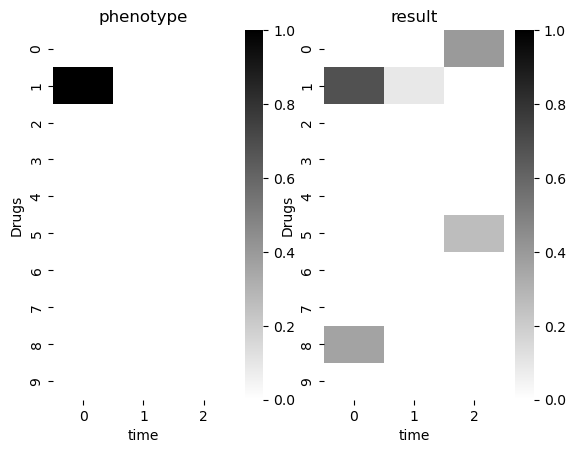

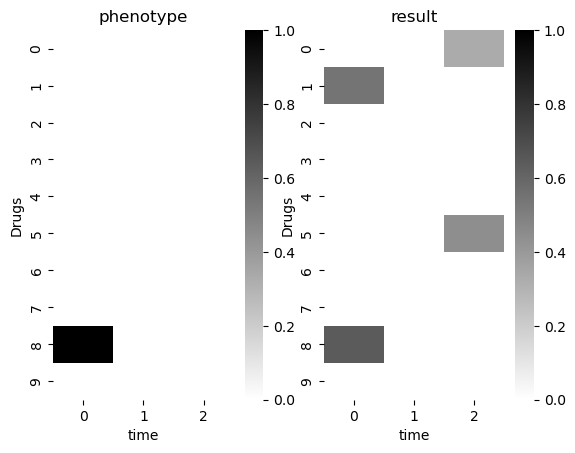

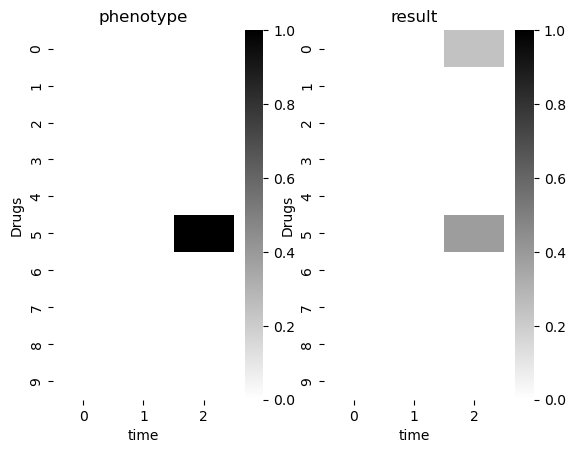

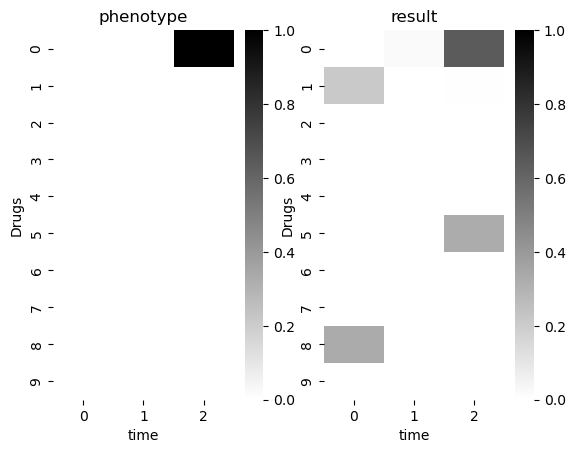

In [797]:
# visualize the phenotype
reordered_pheno, reordered_pathways = swotted.reorderPhenotypes(Ph_, tw=Tw)
for i in range(R):
    plt.subplot(121)
    sns.heatmap(Ph_[i], vmin=0, vmax=1, cmap="binary")
    plt.ylabel("Drugs")
    plt.xlabel("time")
    plt.title("phenotype")
    plt.subplot(122)
    sns.heatmap(reordered_pheno[i].detach().numpy(), vmin=0, vmax=1, cmap="binary")
    plt.ylabel("Drugs")
    plt.xlabel("time")
    plt.title("result")
    plt.show()


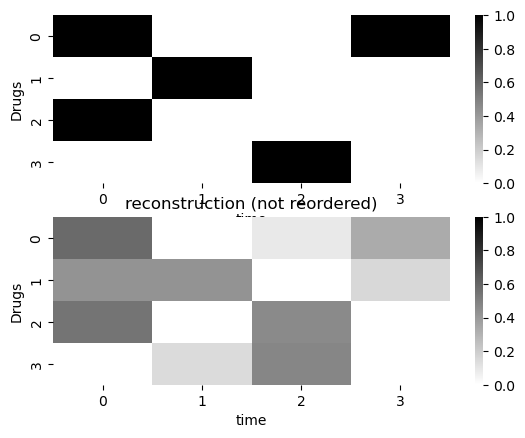

In [798]:
# make decomposition with the train model: it projects the X on the phenotypes of the model
# note that projection can be applied on new data. We use data from the training set for the sake
# of the simplicity
id = 15
W = swotted(X[id : id + 1])
_, W = swotted.reorderPhenotypes(Ph_, W)

# Visual comparison of the care pathways
plt.subplot(211)
sns.heatmap(W_[id], vmin=0, vmax=1, cmap="binary")
plt.ylabel("Drugs")
plt.xlabel("time")
plt.subplot(212)
sns.heatmap(W[0].detach().numpy(), vmin=0, vmax=1, cmap="binary")
plt.ylabel("Drugs")
plt.xlabel("time")
plt.title("reconstruction (not reordered)")
plt.show()


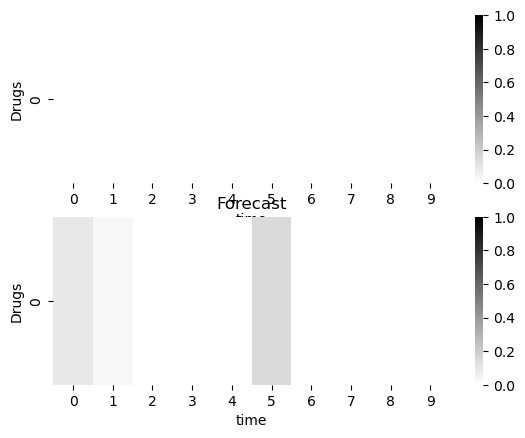

In [799]:

# we can also forecast the end of the :
id = 15
pred = swotted.forecast([X[id][:, :-1]])

# Visual comparison of the care pathways
plt.subplot(211)
sns.heatmap(X[id][:, -1].unsqueeze(0), vmin=0, vmax=1, cmap="binary")
plt.ylabel("Drugs")
plt.xlabel("time")
plt.subplot(212)
sns.heatmap(pred[0].unsqueeze(0), vmin=0, vmax=1, cmap="binary")
plt.ylabel("Drugs")
plt.xlabel("time")
plt.title("Forecast")
plt.show()

In [759]:
irregular_tensor = [
    [1, 2, 3],
    [4, 5],
    [6, 7, 8, 9]
]

irregular_tensor_array = np.array(irregular_tensor, dtype=object)
irregular_tensor_array.shape[0]

3

In [783]:
X_test_irregular = [torch.tensor(irregular_tensor_array[i]) for i in range(irregular_tensor_array.shape[0])]
X_test_irregular

[tensor([1, 2, 3]), tensor([4, 5]), tensor([6, 7, 8, 9])]

In [779]:
# X_test_irregular = []
# for p in range(K):
#     # create a tensor of windows
#     dec = torch.tensordot(Uk[p], Vk, dims=([0], [0]))

#     # now ... windows have to be summed
#     Yp = torch.zeros((N, T))
#     for i in range(T - Tw + 1):
#         Yp[:, i : (i + Tw)] += dec[i]

#     X_test_irregular.append(Yp)

X_test_irregular = torch.stack(X_test_irregular)

RuntimeError: stack expects each tensor to be equal size, but got [3] at entry 0 and [2] at entry 1

In [777]:
X_test_irregular = torch.stack(X_test_irregular)

TypeError: expected Tensor as element 0 in argument 0, but got list

In [769]:
from swotted.utils import Subset

Subset(X, np.arange(len(X)))

In [762]:
X_test_irregular = [
    torch.cat(tuple([irregular_tensor_array[i][j] for j in range(irregular_tensor_array.shape[1])]), axis=1)
    for i in range(irregular_tensor_array.shape[0])
]

TypeError: expected Tensor as element 0 in argument 0, but got int

#### FastSWOTTED model

In [217]:
unique_patients = timed_event_structure['ID_PATIENT'].unique()
unique_care_events = timed_event_structure['Care_Event'].unique()
unique_time_points = timed_event_structure['Time'].unique()

patient_to_index = {patient: idx for idx, patient in enumerate(unique_patients)}

K = len(unique_patients)  #: number of patients
N = len(unique_care_events)  #: number of medical events
T = len(unique_time_points)  #: length of time's stay

tensor = np.zeros((K, N, T), dtype=int)
for _, row in timed_event_structure.iterrows():
    patient_idx = patient_to_index[row['ID_PATIENT']]
    care_event_idx = np.where(unique_care_events == row['Care_Event'])[0][0]
    time_idx = np.where(unique_time_points == row['Time'])[0][0]
    tensor[patient_idx, care_event_idx, time_idx] = 1

X = torch.tensor(tensor, dtype=torch.float32)

# The resulting tensor is a 3D binary tensor
X.shape  # (number of patients, number of care events, number of time points)

torch.Size([1029, 4, 25])

In [218]:
params = {}
params["model"] = {}
params["model"]["non_succession"] = 0.5
params["model"]["sparsity"] = 0.5
params["model"]["rank"] = 3  #: number of phenotypes to discover
params["model"]["twl"] = 3  #: length of time's window
params["model"]["N"] = N
params["model"]["metric"] = "Bernoulli"
params["training"] = {}
params["training"]["batch_size"] = 40
params["training"]["nepochs"] = 100
params["training"]["lr"] = 1e-2
params["predict"] = {}
params["predict"]["nepochs"] = 100
params["predict"]["lr"] = 1e-2

config = OmegaConf.create(params)

# define the model
fastswotted = fastSWoTTeDModule(config)

train_loader = DataLoader(
    fastSWoTTeDDataset(X),
    batch_size=params["training"]["batch_size"],
    shuffle=False,
    collate_fn=lambda x: x,
)

# train the model
trainer = fastSWoTTeDTrainer(
    max_epochs=params["training"]["nepochs"]
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [921]:
trainer.fit(model=fastswotted, train_dataloaders=train_loader)

c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | model        | SlidingWindowConv | 0      | train
  | other params | n/a               | 48     | n/a  
-----------------------------------------------------------
48        Trainable params
0         Non-trainable params
48        Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve perfo

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


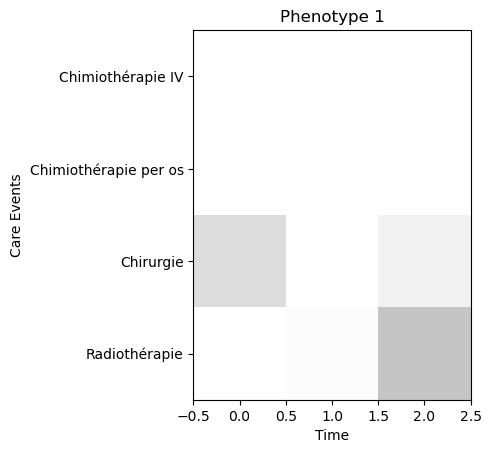

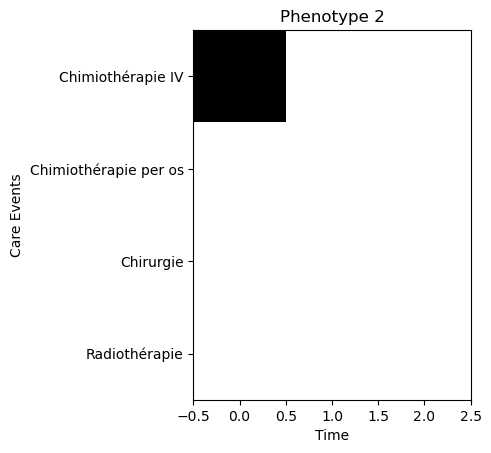

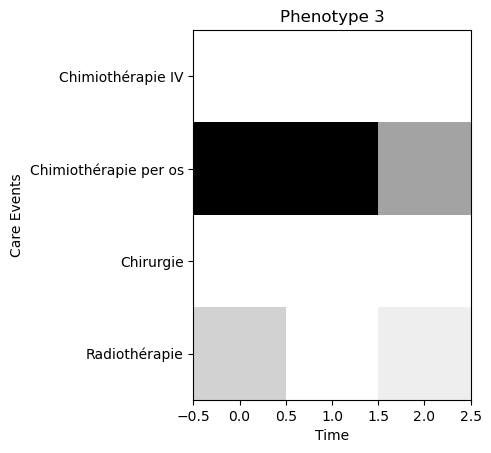

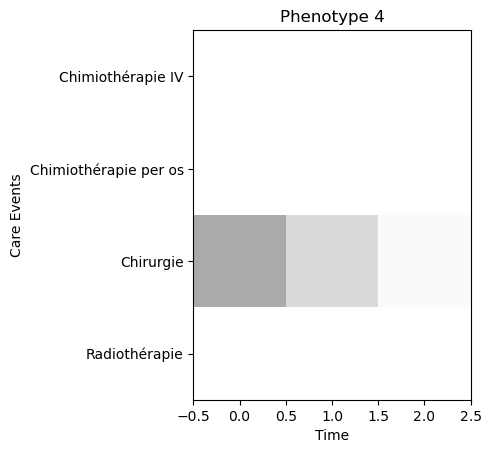

In [928]:
# visualize the phenotypes
Ph = fastswotted.Ph.flip(2).detach().numpy()

for i in range(params["model"]["rank"]):
    plt.imshow(Ph[i], vmin=0, vmax=1, cmap="binary", interpolation='none')
    plt.ylabel("Care Events")
    plt.xlabel("Time")
    plt.title("Phenotype " + str(i+1))
    plt.yticks(range(Ph[i].shape[0]), label_encoder.inverse_transform(range(Ph[i].shape[0])))
    plt.show()

In [923]:
patient_index = np.where(unique_patients == '1102101064')[0][0]
id = patient_index

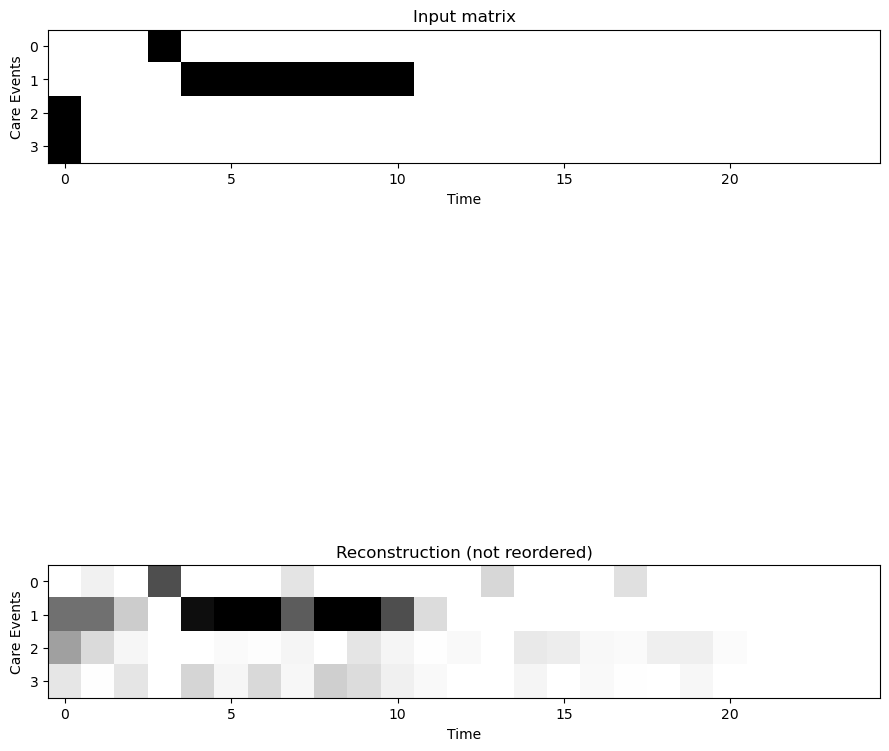

In [931]:
# make decomposition with the train model: it projects the X on the phenotypes of the model
# note that projection can be applied on new data. We use data from the training set for the sake
# of simplicity
W = fastswotted(X[id, :, :].unsqueeze(0))
# Apply reconstruction
Y = fastswotted.model.reconstruct(W, fastswotted.Ph)

# Patient decomposition
plt.figure(figsize=(9, 14))
plt.subplot(211)
plt.imshow(X[id].detach().numpy(), vmin=0, vmax=1, cmap="binary", interpolation='none')
plt.ylabel("Care Events")
plt.xlabel("Time")
plt.title("Input matrix")
plt.subplot(212)
plt.imshow(Y[0].detach().numpy(), vmin=0, vmax=1, cmap="binary", interpolation='none')
plt.ylabel("Care Events")
plt.xlabel("Time")
plt.title("Reconstruction (not reordered)")
plt.tight_layout()
plt.show()

In [932]:
Ph.shape

(4, 4, 3)

In [933]:
# Project the patients onto the phenotype space
W_all = fastswotted(X)
W_all.shape

torch.Size([908, 4, 23])

In [354]:
# Reshape W_all for clustering
K = X.shape[0]  #: number of patients
W_all_reshaped = W_all.view(K, -1).detach().numpy()
W_all_reshaped.shape

(1640, 637)

In [355]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(W_all_reshaped)

labels = kmeans.labels_
print(labels)

c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


[0 1 0 ... 1 2 2]


#### SWOTTED model

In [45]:
unique_patients = timed_event_structure['ID_PATIENT'].unique()
unique_care_events = timed_event_structure['Care_Event'].unique()
unique_time_points = timed_event_structure['Time'].unique()

patient_to_index = {patient: idx for idx, patient in enumerate(unique_patients)}

K = len(unique_patients)  #: number of patients
N = len(unique_care_events)  #: number of medical events
T = len(unique_time_points)  #: length of time's stay

tensor = np.zeros((K, N, T), dtype=int)
for _, row in timed_event_structure.iterrows():
    patient_idx = patient_to_index[row['ID_PATIENT']]
    care_event_idx = np.where(unique_care_events == row['Care_Event'])[0][0]
    time_idx = np.where(unique_time_points == row['Time'])[0][0]
    tensor[patient_idx, care_event_idx, time_idx] = 1

X = torch.tensor(tensor, dtype=torch.float32)

X.shape  # (number of patients, number of care events, number of time points)

torch.Size([1336, 4, 24])

In [46]:
R = 3  #: number of phenotypes
Tw = 3  #: length of time's window

In [47]:
params = {}
params['model']={}
params['model']['non_succession']=0.5
params['model']['sparsity']=0.5
params['model']['rank']=R
params['model']['twl']=Tw
params['model']['N']=N
params['model']['metric']="Bernoulli"

#some additional parameters of the trainer
params['training']={}
params['training']['lr']=1e-2

#some additional parameters for the projection (decomposition on new sequences)
params['predict']={}
params['predict']['nepochs']=100
params['predict']['lr']=1e-2

config=OmegaConf.create(params)

In [48]:
from swotted import swottedModule, swottedTrainer

# define the model
swotted = swottedModule(config)
# train the model
trainer = swottedTrainer(max_epochs=200)

train_loader = DataLoader(
    Subset(X, np.arange(len(X))),
    batch_size=15,
    # num_workers=31,
    shuffle=False,
    collate_fn=lambda x: x
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [49]:
#train the model
trainer.fit(model=swotted, train_dataloaders=train_loader)

c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | model        | SlidingWindow | 0      | train
  | other params | n/a           | 36     | n/a  
-------------------------------------------------------
36        Trainable params
0         Non-trainable params
36        Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
c:\Users\nicolas.grevet\AppData\Local\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [639]:
# # visualize the phenotypes
# Ph = swotted.Ph.flip(2).detach().numpy()

# # visualize the phenotype
# reordered_pheno, reordered_pathways = swotted.reorderPhenotypes(torch.tensor(Ph), tw=4)

# for i in range(params["model"]["rank"]):
#     plt.subplot(211)
#     plt.imshow(Ph[i], vmin=0, vmax=1, cmap="binary", interpolation='none')
#     plt.ylabel("Care Events")
#     plt.xlabel("Time")
#     plt.title("Phenotype " + str(i+1))
#     plt.yticks(range(Ph[i].shape[0]), label_encoder.inverse_transform(range(Ph[i].shape[0])))
#     plt.show()
#     plt.subplot(212)
#     plt.imshow(reordered_pheno[i].detach().numpy(), vmin=0, vmax=1, cmap="binary", interpolation="nearest")
#     plt.ylabel("Care Events")
#     plt.xlabel("Time")
#     plt.title("result")
#     plt.yticks(range(Ph[i].shape[0]), label_encoder.inverse_transform(range(Ph[i].shape[0])))
#     plt.show()

In [50]:
swotted.Ph.shape

torch.Size([3, 4, 3])

In [51]:
swotted.Ph

Parameter containing:
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.7635e+00, 0.0000e+00, 0.0000e+00],
         [1.5150e+00, 2.2703e-04, 3.1238e-01]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.3129e+01, 9.9061e+00, 8.9212e-02],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 3.1254e-01, 0.0000e+00]],

        [[2.6212e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.9361e-01],
         [0.0000e+00, 9.2415e-03, 3.7616e-02],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]]], requires_grad=True)

In [52]:
patient_index = np.where(unique_patients == '1102101064')[0][0]
id = patient_index
patient_data = X[patient_index]
patient_data

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]])

In [53]:
id = patient_index

# W = swotted(X[id:id+1])
W = swotted(X[id, :, :].unsqueeze(0))
Ph = swotted.Ph.flip(2).detach().numpy()

#reorder the row of the pathway
rPh, rW = swotted.reorderPhenotypes(gen_pheno=torch.tensor(Ph), Wk=W, tw=Tw)
X_pred = swotted.model.reconstruct(rW[0], rPh)

rW[0].shape

torch.Size([3, 22])

In [54]:
W_all = swotted(X)

In [55]:
# Compute the reconstructed X for the entire dataset
# W_all = swotted(X)
X_reconstructed = []
for p in range(K):
    X_reconstructed.append(swotted.model.reconstruct(W_all[p], swotted.Ph))
X_reconstructed = torch.stack(X_reconstructed)

# Compute the FIT metric for the entire dataset
fit_metric = 1 - (torch.norm(X - X_reconstructed) / torch.norm(X))
print(f"FIT metric for the entire dataset: {fit_metric.item():.4f}")

FIT metric for the entire dataset: -3.3406


In [278]:
# import tensorly as tl

# fit = 1 - (tl.norm(X.detach().numpy() - X_reconstructed.detach().numpy()) / tl.norm(X.detach().numpy()))
# fit_percentage = fit * 100

# print(f"Fit metric: {fit_percentage:.2f}%")

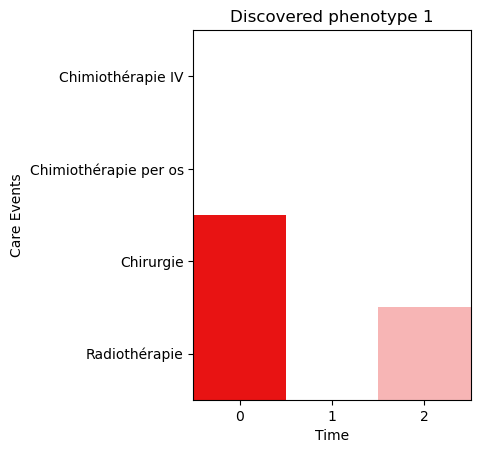

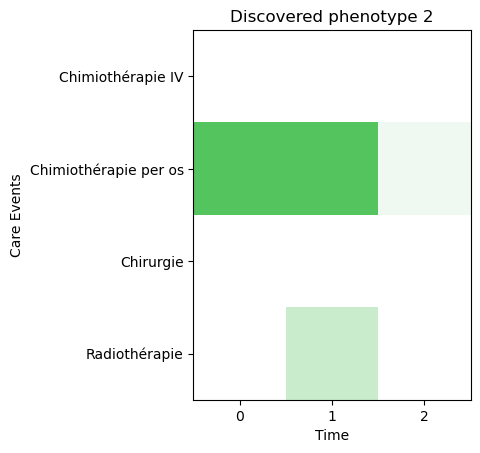

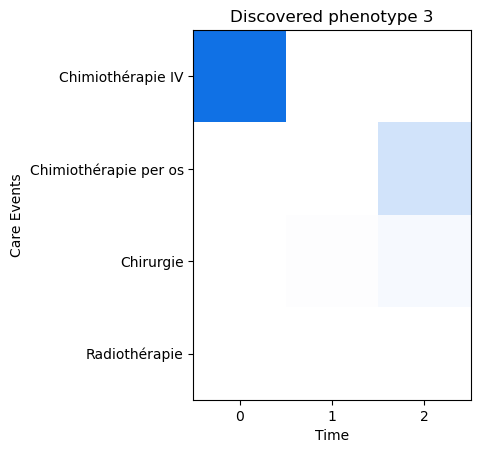

In [56]:
import matplotlib.colors as mcolors

color_code = ['#E81313', '#54C45E', '#1071E5']

for i in range(params["model"]["rank"]):
    # Create a colormap based on the base color
    base_color = color_code[i % len(color_code)]
    cmap = mcolors.LinearSegmentedColormap.from_list(f"custom_cmap_{i}", ["white", base_color])

    # Plot the phenotype matrix with the custom colormap
    plt.imshow(rPh[i].detach().numpy(), vmin=0, vmax=1, cmap=cmap, interpolation='none')
    plt.ylabel("Care Events")
    plt.xticks(range(rPh[i].shape[1]), range(rPh[i].shape[1]))
    plt.xlabel("Time")
    plt.title(f"Discovered phenotype {i + 1}")
    plt.yticks(range(rPh[i].shape[0]), label_encoder.inverse_transform(range(rPh[i].shape[0])))
    # plt.colorbar(label="Intensity")
    plt.show()

In [2]:
type(range(4))

range

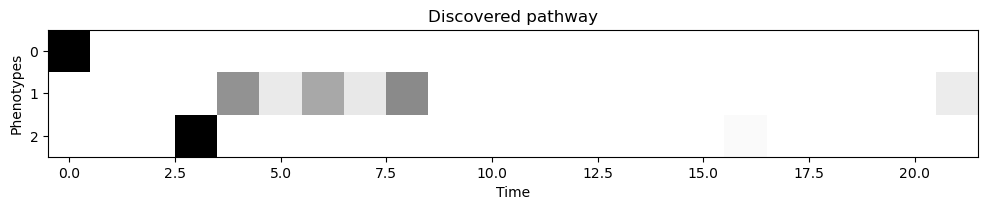

In [57]:
plt.figure(figsize=(12, 8)) 
plt.imshow(rW[0].detach().numpy(), vmin=0, vmax=1, cmap="binary", interpolation="nearest")
plt.ylabel("Phenotypes")
plt.yticks(range(rW[0].shape[0]), )
plt.xlabel("Time")
plt.title("Discovered pathway")
plt.show()


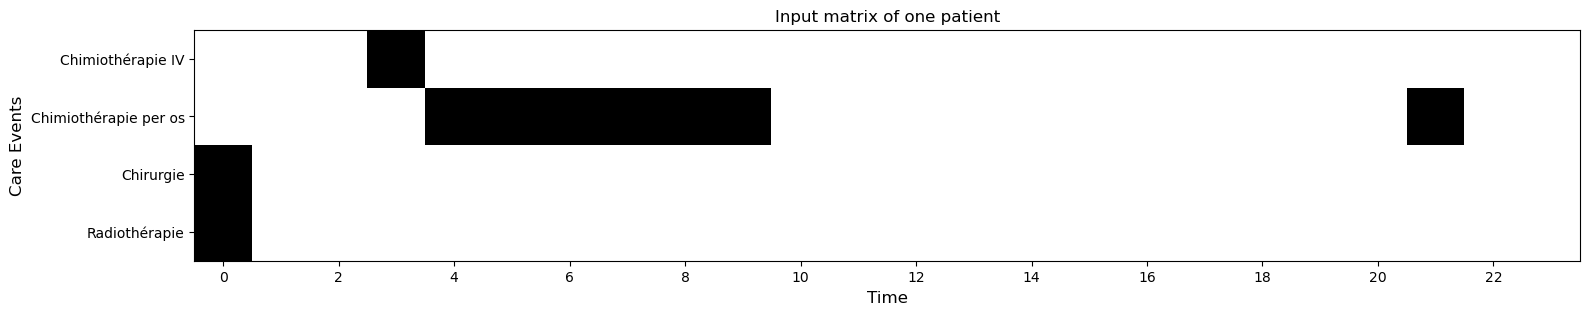

In [58]:
T = X[id].shape[1]

fig, axs = plt.subplots(figsize=(16, 12))
axs.imshow(X[id], vmin=0, vmax=1, cmap="binary", interpolation='none')
axs.set_title("Input matrix of one patient", fontsize=12) 
axs.set_xlabel("Time", fontsize=12)
axs.set_ylabel("Care Events", fontsize=12)
axs.set_xticks(np.arange(0, T, 2)) 
axs.set_yticks(range(X[id].shape[0]))
axs.set_yticklabels(label_encoder.inverse_transform(range(X[id].shape[0])), fontsize=10)
plt.tight_layout()
plt.show()

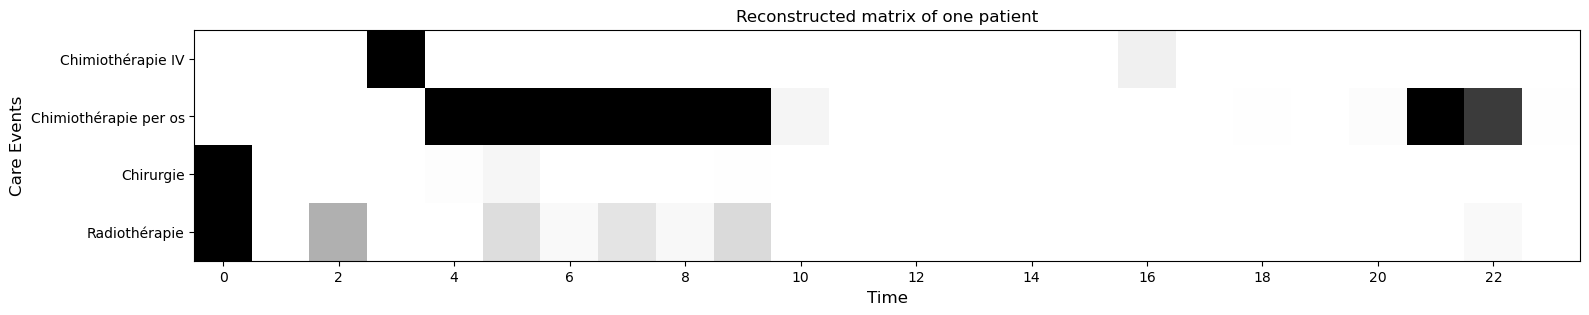

In [59]:
fig, axs = plt.subplots(figsize=(16, 12))
axs.imshow(X_pred.detach().numpy(), vmin=0, vmax=1, cmap="binary", interpolation='none')
axs.set_title("Reconstructed matrix of one patient", fontsize=12) 
axs.set_xlabel("Time", fontsize=12)
axs.set_ylabel("Care Events", fontsize=12)
axs.set_xticks(np.arange(0, T, 2)) 
axs.set_yticks(range(X[id].shape[0]))
axs.set_yticklabels(label_encoder.inverse_transform(range(X[id].shape[0])), fontsize=10)
plt.tight_layout()
plt.show()

In [478]:
FITx = success_rate(X[id], X_pred)
FITx

-1.666688619090619

Création d’un vecteur de caractéristiques par patient Une fois le modèle entraîné, chaque patient est associé à une matrice 𝑊 qui constitue son « chemin », c’est-à-dire la séquence (ou l’occurrence) des phénotypes durant son séjour. Pour passer au clustering, vous pouvez :

Résumer l’activité de chaque phénotype : Calculer, par exemple, le nombre total d’occurrences ou la durée cumulée de chaque phénotype dans le parcours du patient. Cela permet de transformer la matrice 𝑊 en un vecteur 𝑣∈𝑅
où chaque composante représente l’importance ou la fréquence du phénotype 𝑟 pour le patient.

Extraire des indicateurs temporels : En plus de la fréquence, vous pouvez intégrer des informations sur le début, la fin ou les intervalles entre les occurrences pour capturer la dynamique temporelle.

Normalisation et réduction de dimension (optionnel) Avant d’appliquer un algorithme de clustering, il peut être pertinent de normaliser ces vecteurs ou d’utiliser des techniques de réduction de dimension (comme PCA ou t-SNE) pour visualiser les relations entre les patients dans un espace plus compact et interprétable.

In [61]:
W_all = torch.stack(W_all)
W_all.shape

torch.Size([1336, 3, 22])

In [293]:
# # Reshape W_all for clustering
# W_all_reshaped = X_reconstructed.view(K, -1).detach().numpy()
# W_all_reshaped.shape

In [62]:
# Calculate the total occurrences or cumulative duration of each phenotype for each patient
# Summing along the time axis (axis=2)
phenotype_summary = W_all.sum(axis=2).detach().numpy()

phenotype_summary_df = pd.DataFrame(
    phenotype_summary, 
    columns=[f'Phenotype_{i+1}' for i in range(phenotype_summary.shape[1])]
)

phenotype_summary_df['ID_PATIENT'] = unique_patients
phenotype_summary_df.head()

,Phenotype_1,Phenotype_2,Phenotype_3,ID_PATIENT
0,0.002382,1.680183,1.017303,1101100224
1,0.010456,1.534751,1.008172,1101105979
2,2.165024,3.061919,0.040466,1101106819
3,0.006037,2.866943,0.975693,1101107369
4,0.005467,1.618102,1.008130,1101108956


In [63]:
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(phenotype_summary_df.drop(columns=['ID_PATIENT']))
data_scaled = (data_scaled - data_scaled.min(axis=0)) / (data_scaled.max(axis=0) - data_scaled.min(axis=0))
distance_matrix = pdist(data_scaled, metric='euclidean')

phenotype_summary_df_scaled = pd.DataFrame(
    data_scaled, 
    columns=phenotype_summary_df.columns[:-1], 
    index=phenotype_summary_df['ID_PATIENT']
)
phenotype_summary_df_scaled.head()

,Phenotype_1,Phenotype_2,Phenotype_3
ID_PATIENT,,,
1101100224,0.000527,0.312476,0.345030
1101105979,0.002313,0.285428,0.341925
1101106819,0.478873,0.569447,0.012851
1101107369,0.001335,0.533186,0.330881
1101108956,0.001209,0.300930,0.341911


In [64]:
from scipy.cluster.hierarchy import linkage, fcluster, leaves_list
linkage_matrix = linkage(distance_matrix, method='ward')
leaf_order = leaves_list(linkage_matrix)

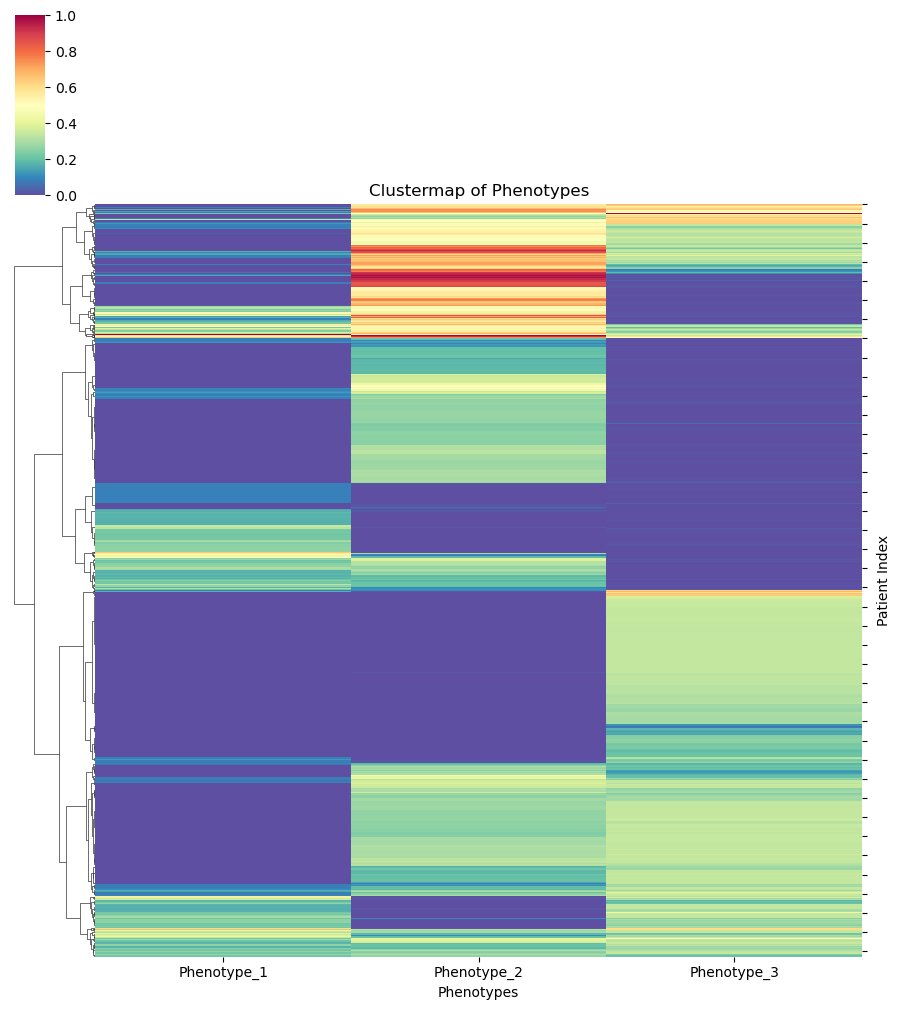

In [65]:
# Create the clustermap
clustermap = sns.clustermap(phenotype_summary_df_scaled,
                            cmap='Spectral_r',
                            metric='precomputed',
                            method='ward',
                            row_linkage=linkage_matrix,
                            row_cluster=True, 
                            col_cluster=False,
                            dendrogram_ratio=(.1, .2),
                            cbar_pos=(0.02, 0.8, 0.03, 0.18))

# Set labels and title on the clustermap's axes
clustermap.ax_heatmap.set_xlabel("Phenotypes")
clustermap.ax_heatmap.set_ylabel("Patient Index")
clustermap.ax_heatmap.set_yticklabels([])
clustermap.ax_heatmap.set_title('Clustermap of Phenotypes')


plt.show()


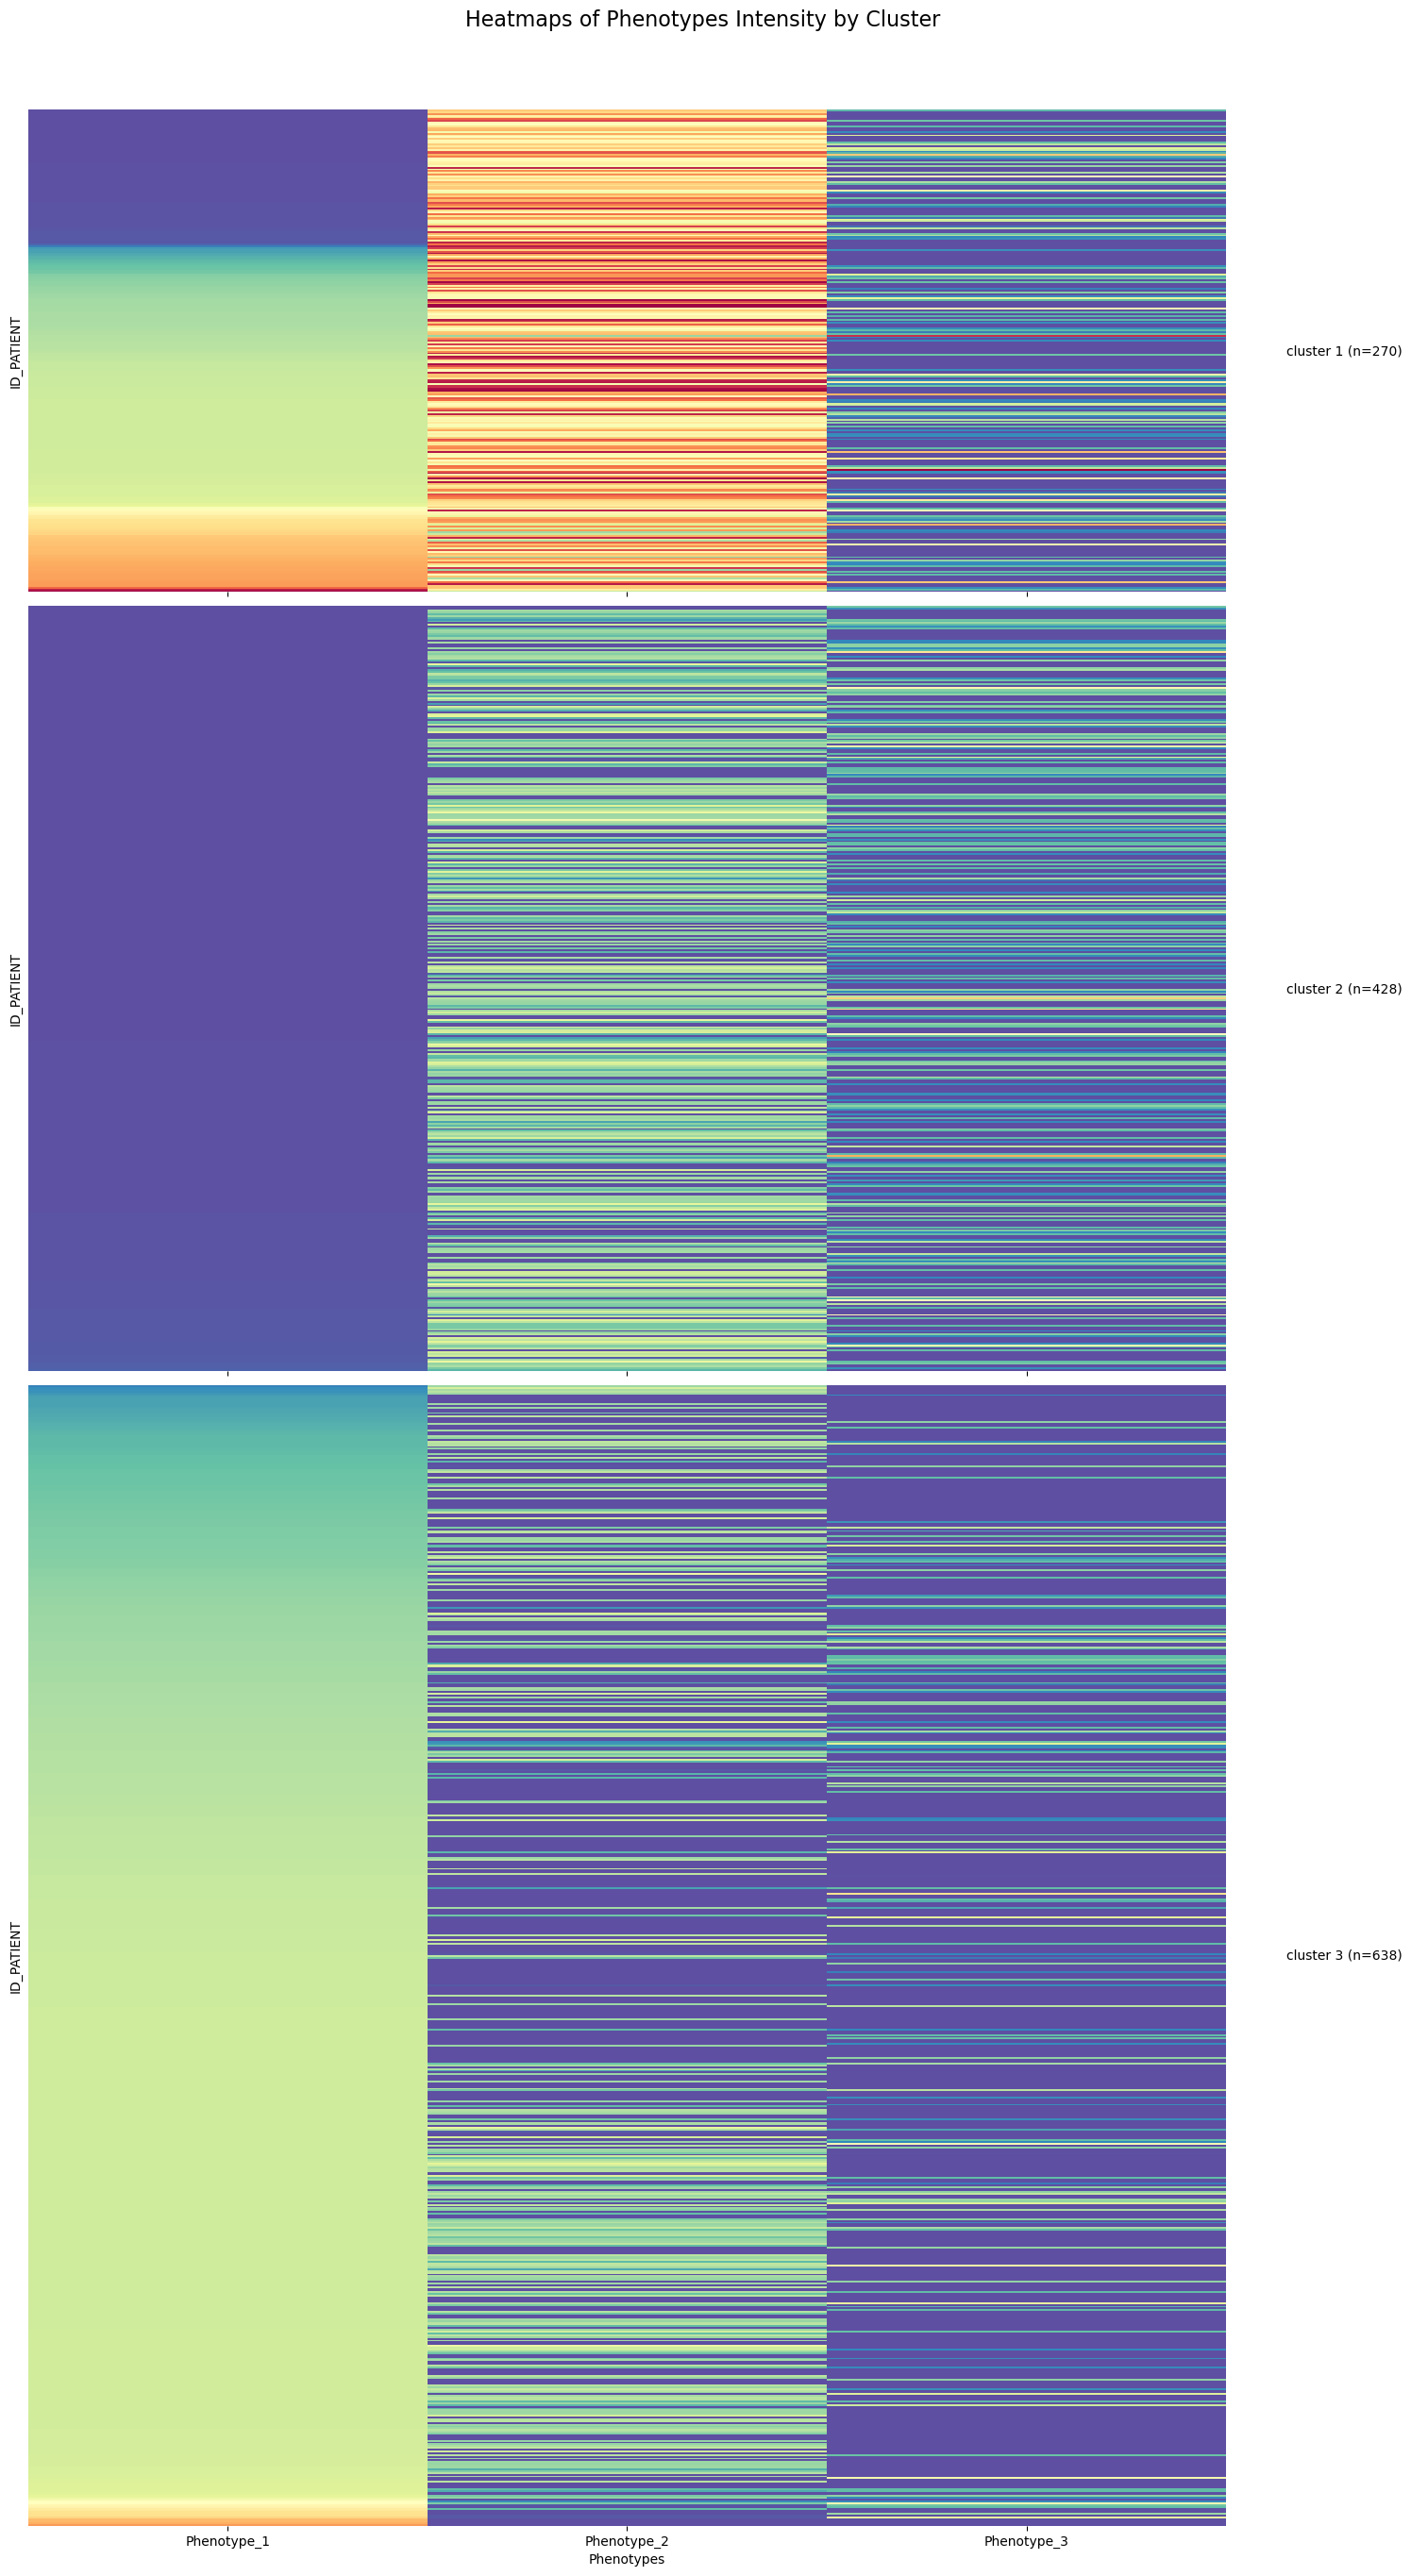

In [518]:
clusters = fcluster(linkage_matrix, 3, criterion='maxclust')

leaves_order = leaf_order
reordered_data = phenotype_summary_df_scaled.iloc[leaves_order]
reordered_clusters = clusters[leaves_order]

num_clusters = len(np.unique(clusters))
cluster_data = {}
for cluster_label in range(1, num_clusters + 1):
    cluster_indices = np.where(reordered_clusters == cluster_label)[0]
    cluster_df = reordered_data.iloc[cluster_indices]
    if sorted:
        cluster_df = cluster_df.sort_values(by=cluster_df.columns.tolist())
    cluster_data[cluster_label] = cluster_df
    
    heights = [len(cluster_df) for cluster_df in cluster_data.values()]
num_rows = num_clusters
num_cols = min(1, num_clusters)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, sum(heights)* 0.02), sharex=True, gridspec_kw={'height_ratios': heights})

# if num_clusters == 2:
#     axs = np.array([axs])
# if num_clusters % 2 != 0:
#     fig.delaxes(axs[-1, -1])  

# viridis_colors_list = [plt.cm.viridis(i) for i in np.linspace(0, 1, len(cluster_data[1].columns))]
# legend_handles = [plt.Rectangle((0, 0), 1, 1, color=viridis_colors_list[i]) for i in range(len(cluster_data[1].columns))]          

# colors = sns.color_palette("viridis", n_colors=len(cluster_data[1].columns))    
vmin, vmax = 0, 1
# plt.figure(figsize=(10, 15))
plt.subplots_adjust(hspace=2, wspace=0.5)
plt.suptitle('Heatmaps of Phenotypes Intensity by Cluster', fontsize=16, y=1.02)
for cluster_label, (cluster_df, ax) in enumerate(zip(cluster_data.items(), axs)):
    #sns.heatmap(cluster_df[1].drop(id_col, axis=1).replace(label_to_encoded), cmap=colors, cbar=False, ax=ax, yticklabels=False)
    heatmap_data = cluster_df[1]
    heatmap_data = heatmap_data.infer_objects(copy=True)
    sns.heatmap(heatmap_data, cmap='Spectral_r', cbar=False, ax=ax, yticklabels=False, 
                vmin=vmin, vmax=vmax)
    ax.tick_params(axis='x')
    ax.text(1.05, 0.5, f'cluster {cluster_label+1} (n={len(cluster_df[1])})', transform=ax.transAxes, ha='left', va='center')
axs[-1].set_xlabel('Phenotypes')


# plt.legend(handles=legend_handles, loc='lower right', ncol=1, title='Statuts')
plt.tight_layout()
plt.show()

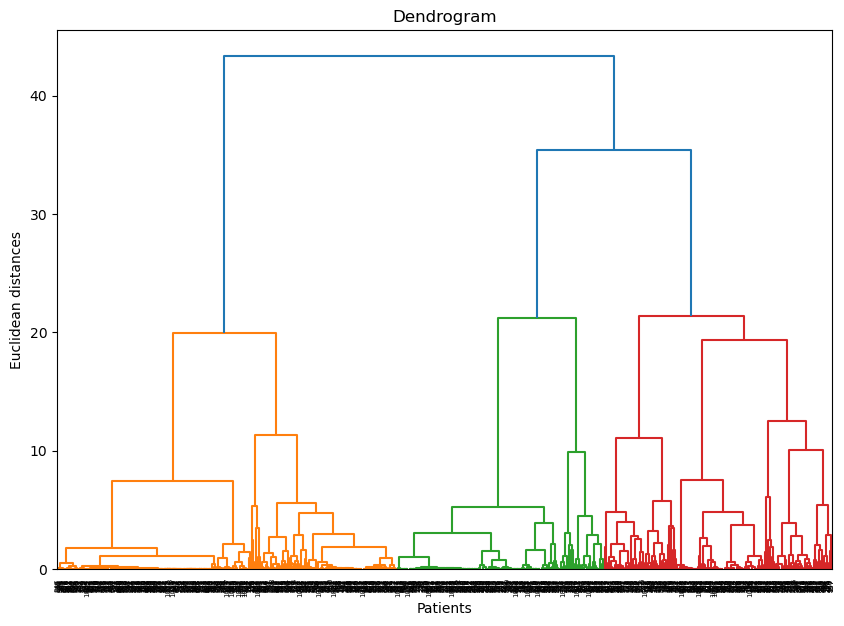

In [292]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

scaler = StandardScaler()
data_scaled = scaler.fit_transform(phenotype_summary_df.drop(columns=['Patient_ID']))

plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(data_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Patients')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
n_clusters = 3 
cah = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
clusters = cah.fit_predict(data_scaled)

phenotype_summary_df['Cluster'] = clusters
phenotype_summary_df.head()

,Phenotype_1,Phenotype_2,Phenotype_3,Patient_ID,Cluster
0,1.022673,0.010673,1.614332,1101105979,1
1,0.435515,0.010912,1.822512,1101108956,1
2,0.012415,0.005591,1.620209,1101110539,2
3,1.007129,0.005944,0.001166,1102100714,1
4,0.732349,0.563179,1.866680,1102101064,1


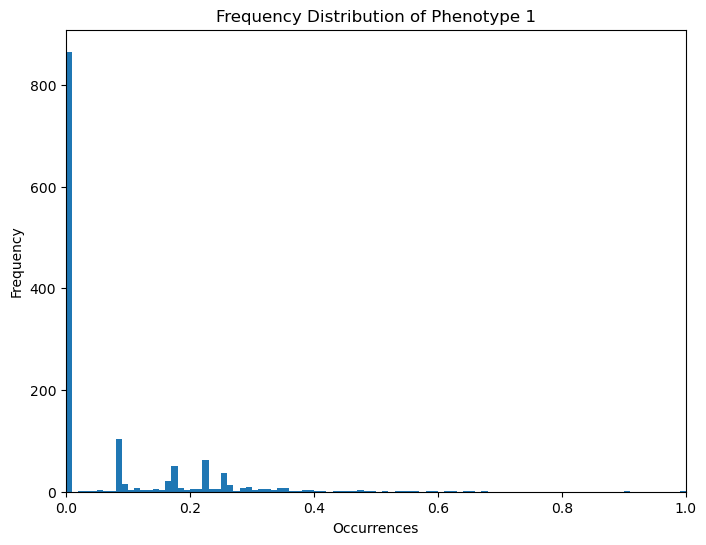

In [73]:
phenotype_summary_df_scaled['Phenotype_1'].plot(kind='hist', bins=100, figsize=(8, 6))
plt.title('Frequency Distribution of Phenotype 1')
plt.xlabel('Occurrences')
plt.ylabel('Frequency')
plt.xlim(0, 1)  # Set the range of the x-axis
plt.show()

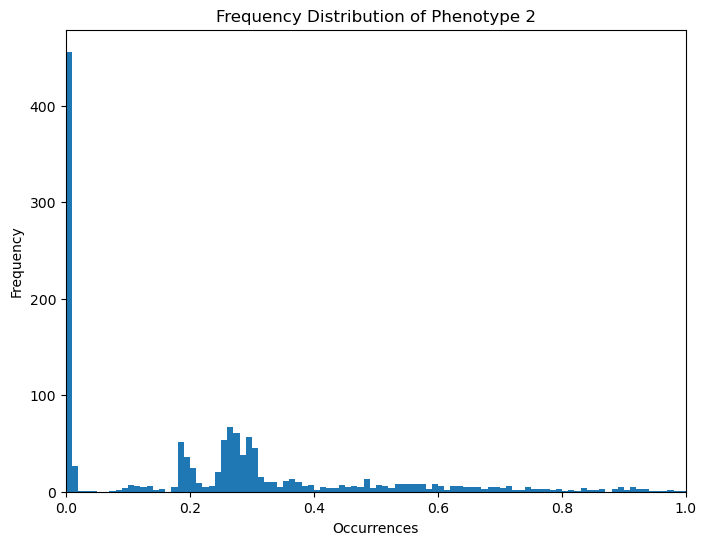

In [74]:
phenotype_summary_df_scaled['Phenotype_2'].plot(kind='hist', bins=100, figsize=(8, 6))
plt.title('Frequency Distribution of Phenotype 2')
plt.xlabel('Occurrences')
plt.ylabel('Frequency')
plt.xlim(0, 1)  # Set the range of the x-axis
plt.show()

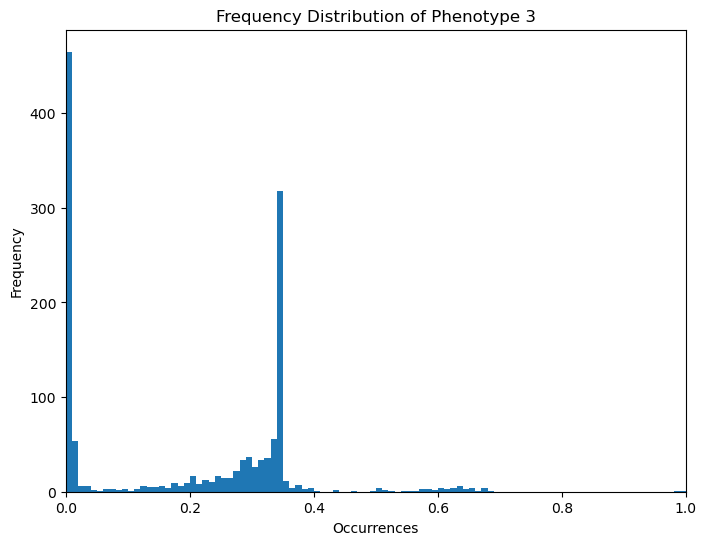

In [75]:
phenotype_summary_df_scaled['Phenotype_3'].plot(kind='hist', bins=100, figsize=(8, 6))
plt.title('Frequency Distribution of Phenotype 3')
plt.xlabel('Occurrences')
plt.ylabel('Frequency')
plt.xlim(0, 1)  # Set the range of the x-axis
plt.show()

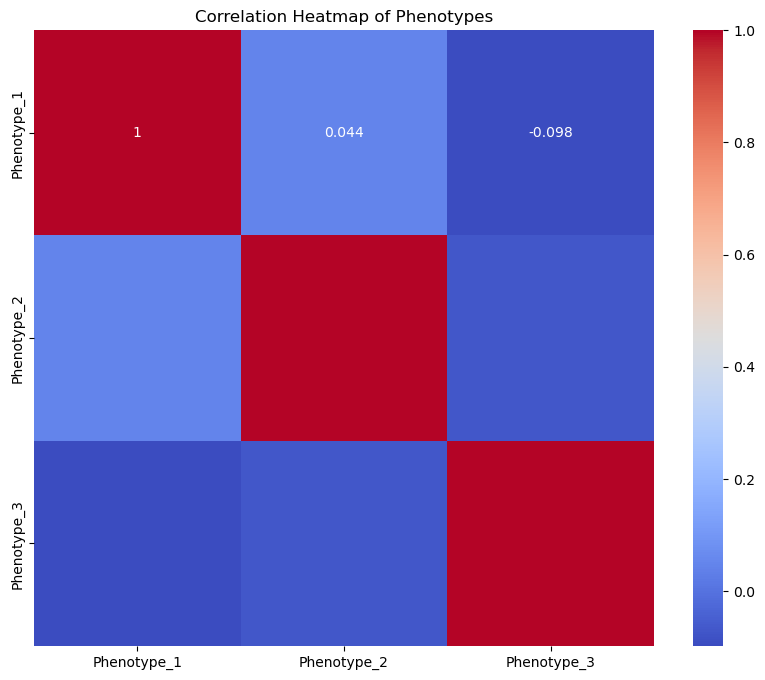

In [77]:
plt.figure(figsize=(10, 8))
sns.heatmap(phenotype_summary_df_scaled.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Phenotypes')
plt.show()

import seaborn as sns

Here are some analytical plots you can create for `phenotype_summary_df`:

1. **Bar Plot**: Show the average or total occurrences of each phenotype across all patients.
    ```python
    phenotype_summary_df.drop(columns=['Patient_ID']).mean().plot(kind='bar', figsize=(10, 6))
    plt.title('Average Occurrences of Each Phenotype')
    plt.xlabel('Phenotypes')
    plt.ylabel('Average Occurrences')
    plt.show()
    ```

2. **Box Plot**: Display the distribution of occurrences for each phenotype.
    ```python
    phenotype_summary_df.drop(columns=['Patient_ID']).plot(kind='box', figsize=(10, 6))
    plt.title('Distribution of Phenotype Occurrences')
    plt.ylabel('Occurrences')
    plt.show()
    ```

3. **Heatmap**: Visualize the correlation between phenotypes.
    ```python
    plt.figure(figsize=(10, 8))
    sns.heatmap(phenotype_summary_df.drop(columns=['Patient_ID']).corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap of Phenotypes')
    plt.show()
    ```

4. **Histogram**: Show the frequency distribution of occurrences for a specific phenotype.
    ```python
    phenotype_summary_df['Phenotype_1'].plot(kind='hist', bins=20, figsize=(8, 6))
    plt.title('Frequency Distribution of Phenotype 1')
    plt.xlabel('Occurrences')
    plt.ylabel('Frequency')
    plt.show()
    ```

5. **Pair Plot**: Explore pairwise relationships between phenotypes.
    ```python
    sns.pairplot(phenotype_summary_df.drop(columns=['Patient_ID']))
    plt.show()
    ```

    ```python
    sns.clustermap(phenotype_summary_df.drop(columns=['Patient_ID']), cmap='viridis', figsize=(12, 10))
    plt.title('Clustered Heatmap of Phenotypes')
    plt.show()

These plots can help you understand the distribution, relationships, and patterns in the phenotype data.

Number of patients in each cluster:
1    452
0    302
2    275
Name: count, dtype: int64


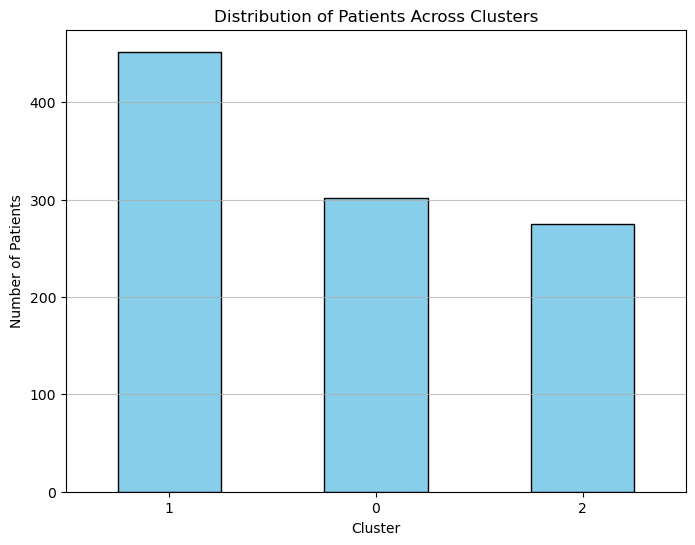

In [295]:
cluster_counts = pd.Series(clusters).value_counts()
print("Number of patients in each cluster:")
print(cluster_counts)

plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Patients Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.75)
plt.show()

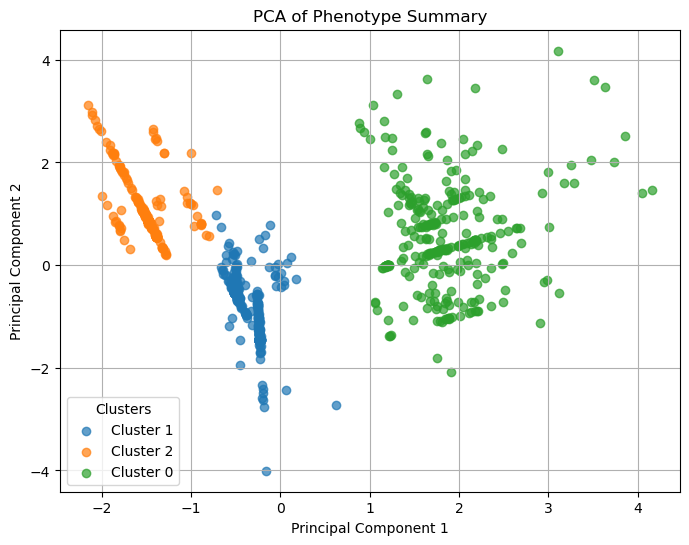

In [ ]:
from sklearn.decomposition import PCA

numerical_data = phenotype_summary_df.drop(columns=['Patient_ID'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = phenotype_summary_df['Cluster']
pca_df['Patient_ID'] = phenotype_summary_df['Patient_ID']

plt.figure(figsize=(8, 6))
for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title('PCA of Phenotype Summary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters')
plt.grid(True)
plt.show()

### Poumon

In [389]:
data_poumon = [df[df['ID_PATIENT'].isin(list(CDV_poumon_plus['ID_PATIENT'].values))] for df in data_all]

In [393]:
data_2009_poumon = data_poumon[0].drop_duplicates()
data_2010_poumon = data_poumon[1].drop_duplicates()
data_2011_poumon = data_poumon[2].drop_duplicates()
data_2012_poumon = data_poumon[3].drop_duplicates()
data_2013_poumon = data_poumon[4].drop_duplicates()
data_2014_poumon = data_poumon[5].drop_duplicates()
data_2015_poumon = data_poumon[6].drop_duplicates()
data_2016_poumon = data_poumon[7].drop_duplicates()

df_poumon = pd.concat([data_2009_poumon, data_2010_poumon, data_2011_poumon, data_2012_poumon, data_2013_poumon, data_2014_poumon, data_2015_poumon, data_2016_poumon], ignore_index=True)
# print(df_poumon.ID_PATIENT.nunique())

# convert 'nan' string to NaN
df_poumon = df_poumon.replace('nan', np.nan)

# apply function convert_numeric_date to all columns containing 'DATE_' in their name
for col in df_poumon.columns:
    if 'DATE_' in col :
        df_poumon[col] = df_poumon[col].apply(convert_numeric_date)

df_poumon = df_poumon.dropna(axis=1, how='all')
print(df_poumon.ID_PATIENT.nunique())

394


In [423]:
exemple = df_poumon.merge(CDV_poumon_plus, on='ID_PATIENT', how='left')
exemple['DATE'] = exemple[['DATE_PRESC', 'DATE_DELIV', 'DATE_HOSPIT', 'DATE_ENTREE', 'DATE_SORTIE']].bfill(axis=1).iloc[:, 0]
exemple['AGE_HOSPIT'] = (pd.to_datetime(exemple['DATE_HOSPIT']) - pd.to_datetime(exemple['FC_DateNaissance'])).dt.days // 365

In [440]:
exemple1 = exemple[exemple.ID_PATIENT == '1162409535'].dropna(subset=['DATE'])
exemple1 = exemple1.sort_values(by=['DATE'])
exemple1 = exemple1[exemple1['DATE']>='2016-07-18']

In [447]:
cols = ['ID_PATIENT', 'DATE','DATE_HOSPIT','DATE_PRESC','DATE_DELIV','LIB_PREST','LIB_SPE','QUANTITE','LIB_DIAG_PRINC','LIB_DIAG_REL','LIB_DIAG','LIB_ACTE','LIB_BIO','LIB_CCAM','ACTIVITE_CCAM','LIB_CAT_ETAB','LIB_GHS','LIB_LPP','LIB_CIP','LIB_ATC','LIB_EPH']

In [449]:
exemple1[cols].to_excel((os.path.join(folder_path0, 'exemple1.xlsx')), index=False)

In [435]:
cols_to_keep = ['ID_PATIENT', 'DATE', 'DATE_PRESC', 'DATE_DELIV', 'DATE_HOSPIT', 'DATE_ENTREE', 'DATE_SORTIE', 'AGE_HOSPIT'] 
exemple1[cols_to_keep].dropna(subset=['DATE'])  

,ID_PATIENT,DATE,DATE_PRESC,DATE_DELIV,DATE_HOSPIT,DATE_ENTREE,DATE_SORTIE,AGE_HOSPIT
0,1162409535,2010-02-25,2010-02-25,2010-03-02,NaT,NaT,NaT,NaN
1,1162409535,2010-02-25,2010-02-25,2010-03-02,NaT,NaT,NaT,NaN
2,1162409535,2010-02-25,2010-02-25,2010-03-02,NaT,NaT,NaT,NaN
3,1162409535,2010-02-25,2010-02-25,2010-03-02,NaT,NaT,NaT,NaN
4,1162409535,2010-02-25,2010-02-25,2010-03-02,NaT,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...
650,1162409535,2016-12-27,2016-12-27,2016-12-27,NaT,NaT,NaT,NaN
651,1162409535,2016-12-27,2016-12-27,2016-12-27,NaT,NaT,NaT,NaN
652,1162409535,2016-12-27,2016-12-27,2016-12-27,NaT,NaT,NaT,NaN
653,1162409535,2016-12-27,2016-12-27,2016-12-27,NaT,NaT,NaT,NaN


In [428]:
exemple1.iloc[575632:575656]

,DATE


In [ ]:
df_poumon_subset = df_poumon.merge(
    CDV_poumon_plus[['ID_PATIENT', 'FC_Sexe', 'FC_AgeDiag_R0']],
    on='ID_PATIENT',
    how='left'
).dropna(subset=['FC_Sexe', 'FC_AgeDiag_R0'])
df_poumon_subset.reset_index(drop=True, inplace=True)
df_poumon_subset

,ID_PATIENT,DATE_PRESC,DATE_DELIV,CODE_CCAM,CODE_ATC,FC_Sexe,FC_AgeDiag_R0
0,1101106164,2009-02-05,2009-02-05,NaN,A01AB03,2.0,39.0
1,1101106164,2009-02-05,2009-02-05,NaN,N02AC54,2.0,39.0
2,1101106164,2009-02-05,2009-02-05,NaN,J01RA04,2.0,39.0
3,1101106164,2009-03-13,2009-03-19,NaN,A01AB11,2.0,39.0
4,1101106164,2009-03-13,2009-03-19,NaN,N02AC54,2.0,39.0
...,...,...,...,...,...,...,...
194808,2394100059,2016-12-17,2016-12-17,NaN,,1.0,56.0
194809,2394100059,2016-12-17,2016-12-17,NaN,N06AB03,1.0,56.0
194810,2394100059,2016-12-17,2016-12-17,NaN,R03AC02,1.0,56.0
194811,2394100059,2016-12-17,2016-12-17,NaN,R03BB04,1.0,56.0


In [ ]:
df_poumon_subset.ID_PATIENT.nunique()
# df_poumon_subset[['ID_PATIENT','FC_Sexe']].drop_duplicates()

394

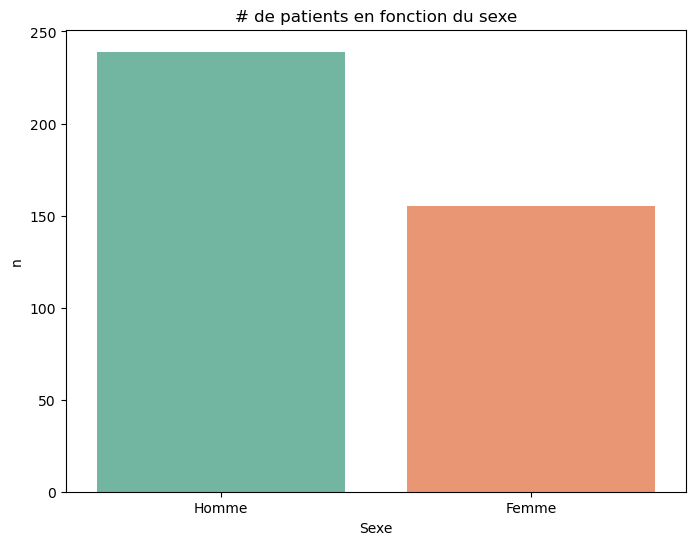

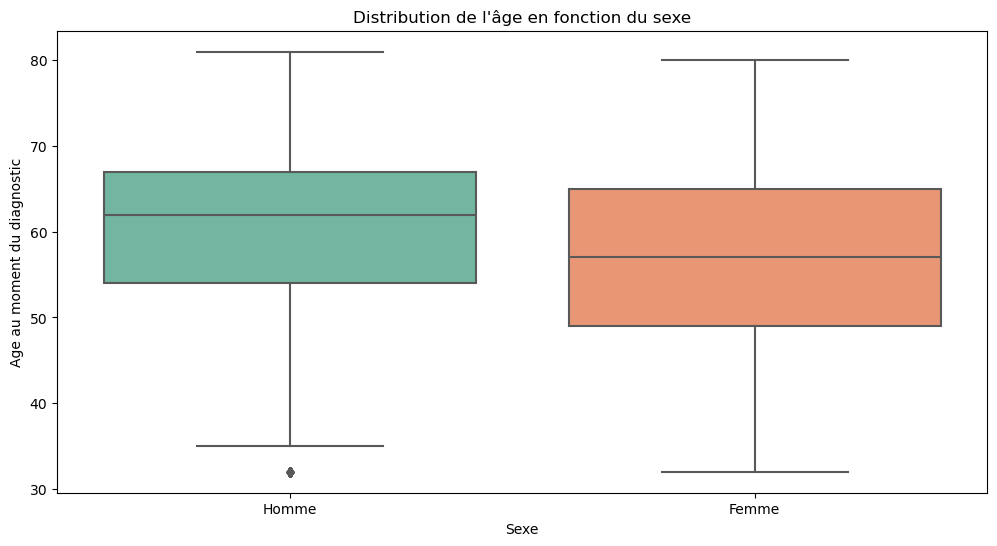

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the count of patients by sex
plt.figure(figsize=(8, 6))
sns.countplot(data=df_poumon_subset[['ID_PATIENT','FC_Sexe']].drop_duplicates(), x='FC_Sexe', palette='Set2')
plt.xticks([0, 1], ['Homme', 'Femme'])
plt.title('# de patients en fonction du sexe')
plt.xlabel('Sexe')
plt.ylabel('n')
plt.show()

# Plot the distribution of age by sex
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_poumon_subset, x='FC_Sexe', y='FC_AgeDiag_R0', palette='Set2')
plt.xticks([0, 1], ['Homme', 'Femme'])
plt.title('Distribution de l\'âge en fonction du sexe')
plt.xlabel('Sexe')
plt.ylabel('Age au moment du diagnostic')
plt.show()

### liste_analytique_ccam_descriptive_a_usage_pmsi_v5_2016

In [ ]:
liste_ccam_2016 = pd.read_excel(r'C:\\Users\\nicolas.grevet\\Downloads\\liste_analytique_ccam_descriptive_a_usage_pmsi_v5_2016.xls', sheet_name='CCAM_Final_2017')

# remove the rows with NaN in the first column
liste_ccam_2016 = liste_ccam_2016.dropna(subset=[liste_ccam_2016.columns[0]])
#remove the columns
liste_ccam_2016 = liste_ccam_2016.drop(liste_ccam_2016.columns[[1, 4, 5, 6, 7, 8, 9, 10]], axis=1)
#rename the columns
liste_ccam_2016.columns = ['Subdivision', 'CODE_CCAM', 'LIB_ACTE']
#apply string type to Subdivision and CODE_CCAM
liste_ccam_2016['Subdivision'] = liste_ccam_2016['Subdivision'].astype(str)
#remove duplicates in Subdivision
liste_ccam_2016 = liste_ccam_2016.drop_duplicates(subset=['Subdivision'])
liste_ccam_2016.reset_index(drop=True, inplace=True)  

liste_ccam_2016

,Subdivision,CODE_CCAM,LIB_ACTE
0,01,NaN,"SYSTÈME NERVEUX CENTRAL, PÉRIPHÉRIQUE ET AUTONOME"
1,01.01,NaN,ACTES DIAGNOSTIQUES SUR LE SYSTÈME NERVEUX
2,01.01.01,NaN,Explorations électrophysiologiques du système ...
3,01.01.01.01,NaN,Électromyographie [EMG]
4,AHQP001,AHQP001,"Électromyographie par électrode de surface, sa..."
...,...,...,...
9839,B,B,Majoration du tarif pour acte de radiographie ...
9840,H,H,"Modificateur numérique pour radiothérapie, niv..."
9841,Q,Q,"Modificateur numérique pour radiothérapie, niv..."
9842,V,V,"Modificateur numérique pour radiothérapie, niv..."


In [ ]:
for idx, char in enumerate(liste_ccam_2016.Subdivision):
    if char in ['6','7','8']:
        liste_ccam_2016.drop(idx, inplace=True)
    else:
        if len(char.split('.')) == 1 and pd.isna(liste_ccam_2016.loc[idx,'CODE_CCAM']):
            liste_ccam_2016.loc[idx,'Niveau1'] = char.split('.')[0]
        elif len(char.split('.')) == 2 and pd.isna(liste_ccam_2016.loc[idx,'CODE_CCAM']):
            liste_ccam_2016.loc[idx,'Niveau1'] = char.split('.')[0]
            liste_ccam_2016.loc[idx,'Niveau2'] = char.split('.')[1]    
        elif len(char.split('.')) == 3 and pd.isna(liste_ccam_2016.loc[idx,'CODE_CCAM']):
            liste_ccam_2016.loc[idx,'Niveau1'] = char.split('.')[0]
            liste_ccam_2016.loc[idx,'Niveau2'] = char.split('.')[1]
            liste_ccam_2016.loc[idx,'Niveau3'] = char.split('.')[2]
        elif len(char.split('.')) == 4 and pd.isna(liste_ccam_2016.loc[idx,'CODE_CCAM']):
            liste_ccam_2016.loc[idx,'Niveau1'] = char.split('.')[0]
            liste_ccam_2016.loc[idx,'Niveau2'] = char.split('.')[1]
            liste_ccam_2016.loc[idx,'Niveau3'] = char.split('.')[2]
            liste_ccam_2016.loc[idx,'Niveau4'] = char.split('.')[3]
        elif len(char.split('.')) == 1 and pd.notna(liste_ccam_2016.loc[idx,'CODE_CCAM']):
            last_row_with_len_3 = liste_ccam_2016[(liste_ccam_2016['Niveau3'].notna()) & (liste_ccam_2016.index < idx)].iloc[-1]
            liste_ccam_2016.loc[idx, 'Niveau1'] = last_row_with_len_3['Niveau1']
            liste_ccam_2016.loc[idx, 'Niveau2'] = last_row_with_len_3['Niveau2']
            liste_ccam_2016.loc[idx, 'Niveau3'] = last_row_with_len_3['Niveau3']

liste_ccam_2016.reset_index(drop=True, inplace=True)

# for idx in range(len(liste_ccam_2016) - 1):
#     if pd.notna(liste_ccam_2016.loc[idx, 'Niveau2']) and pd.isna(liste_ccam_2016.loc[idx, 'Niveau3']) and pd.isna(liste_ccam_2016.loc[idx + 1, 'Niveau3']):
#         liste_ccam_2016.loc[idx, 'CODE_CCAM'] = 'Niv. inter'            

liste_ccam_2016.replace('na', np.nan, inplace=True)    
liste_ccam_2016 = liste_ccam_2016[liste_ccam_2016['Niveau4'].isna()]

#In column 'code_ccam' replace all the non missing-values with the values from 'Subdivision'
liste_ccam_2016.loc[liste_ccam_2016['CODE_CCAM'].notna(), 'CODE_CCAM'] = liste_ccam_2016.loc[liste_ccam_2016['CODE_CCAM'].notna(), 'Subdivision']

# Find the index of the row where Niveau1 = '19' and Niveau2 = '03'
drop_index = liste_ccam_2016[(liste_ccam_2016['Niveau1'] == '19') & (liste_ccam_2016['Niveau2'] == '03')].index
if not drop_index.empty:
    liste_ccam_2016 = liste_ccam_2016.loc[:drop_index[0]]

liste_ccam_2016.reset_index(drop=True, inplace=True)  
liste_ccam_2016

,Subdivision,CODE_CCAM,LIB_ACTE,Niveau1,Niveau2,Niveau3,Niveau4
0,01,NaN,"SYSTÈME NERVEUX CENTRAL, PÉRIPHÉRIQUE ET AUTONOME",01,NaN,NaN,NaN
1,01.01,NaN,ACTES DIAGNOSTIQUES SUR LE SYSTÈME NERVEUX,01,01,NaN,NaN
2,01.01.01,NaN,Explorations électrophysiologiques du système ...,01,01,01,NaN
3,AHQP001,AHQP001,"Électromyographie par électrode de surface, sa...",01,01,01,NaN
4,AHQP002,AHQP002,"Électromyographie par électrode de surface, av...",01,01,01,NaN
...,...,...,...,...,...,...,...
8777,YYYY284,YYYY284,Supplément pour pose de 12 dents contreplaquée...,19,02,11,NaN
8778,YYYY236,YYYY236,Supplément pour pose de 13 dents contreplaquée...,19,02,11,NaN
8779,YYYY353,YYYY353,Supplément pour pose de 14 dents contreplaquée...,19,02,11,NaN
8780,YYYY465,YYYY465,Supplément pour examen spécifique préalable et...,19,02,11,NaN


In [ ]:
liste_ccam_2016[liste_ccam_2016['CODE_CCAM'].shift(-1).isna() | liste_ccam_2016['CODE_CCAM'].shift(1).isna() | liste_ccam_2016['CODE_CCAM'].notna()]

,Subdivision,CODE_CCAM,LIB_ACTE,Niveau1,Niveau2,Niveau3,Niveau4
0,01,NaN,"SYSTÈME NERVEUX CENTRAL, PÉRIPHÉRIQUE ET AUTONOME",01,NaN,NaN,NaN
1,01.01,NaN,ACTES DIAGNOSTIQUES SUR LE SYSTÈME NERVEUX,01,01,NaN,NaN
2,01.01.01,NaN,Explorations électrophysiologiques du système ...,01,01,01,NaN
3,AHQP001,AHQP001,"Électromyographie par électrode de surface, sa...",01,01,01,NaN
4,AHQP002,AHQP002,"Électromyographie par électrode de surface, av...",01,01,01,NaN
...,...,...,...,...,...,...,...
8777,YYYY284,YYYY284,Supplément pour pose de 12 dents contreplaquée...,19,02,11,NaN
8778,YYYY236,YYYY236,Supplément pour pose de 13 dents contreplaquée...,19,02,11,NaN
8779,YYYY353,YYYY353,Supplément pour pose de 14 dents contreplaquée...,19,02,11,NaN
8780,YYYY465,YYYY465,Supplément pour examen spécifique préalable et...,19,02,11,NaN


In [ ]:
# Identify rows where the next row has a missing value in the column CODE_CCAM (except row where is not missing in CODE_CCAM)

rows_to_keep =  (
    (liste_ccam_2016['CODE_CCAM'].shift(-1).notna() | liste_ccam_2016['CODE_CCAM'].shift(1).notna()) &
    (liste_ccam_2016['CODE_CCAM'].shift(-1).isna() | liste_ccam_2016['CODE_CCAM'].shift(1).isna() | liste_ccam_2016['CODE_CCAM'].notna())
    )

# Filter the DataFrame to keep only the desired rows
filtered_test = liste_ccam_2016[rows_to_keep].reset_index(drop=True)

filtered_test

,Subdivision,CODE_CCAM,LIB_ACTE,Niveau1,Niveau2,Niveau3,Niveau4
0,01.01.01,NaN,Explorations électrophysiologiques du système ...,01,01,01,NaN
1,AHQP001,AHQP001,"Électromyographie par électrode de surface, sa...",01,01,01,NaN
2,AHQP002,AHQP002,"Électromyographie par électrode de surface, av...",01,01,01,NaN
3,AHQB027,AHQB027,Électromyographie de 1 ou 2 muscles striés au ...,01,01,01,NaN
4,AHQB025,AHQB025,Électromyographie de 1 ou 2 muscles striés au ...,01,01,01,NaN
...,...,...,...,...,...,...,...
8248,YYYY284,YYYY284,Supplément pour pose de 12 dents contreplaquée...,19,02,11,NaN
8249,YYYY236,YYYY236,Supplément pour pose de 13 dents contreplaquée...,19,02,11,NaN
8250,YYYY353,YYYY353,Supplément pour pose de 14 dents contreplaquée...,19,02,11,NaN
8251,YYYY465,YYYY465,Supplément pour examen spécifique préalable et...,19,02,11,NaN


In [ ]:
# Rows with values in Niveau3
dataset_with_niveau3 = filtered_test[filtered_test['Niveau3'].notna()]

# Rows with missing values in Niveau3
dataset_without_niveau3 = filtered_test[filtered_test['Niveau3'].isna()]

# Display the shapes of the resulting datasets
print(f"Rows with Niveau3: {dataset_with_niveau3.shape[0]}")
print(f"Rows without Niveau3: {dataset_without_niveau3.shape[0]}")

Rows with Niveau3: 8110
Rows without Niveau3: 143


In [ ]:
# Group the rows by Niveau1, Niveau2, and Niveau3
grouped_without_niveau3 = dataset_without_niveau3.groupby(['Niveau1', 'Niveau2'])

# Extract the CODE_CCAM for each group
code_ccam_by_group_without_niveau3 = grouped_without_niveau3['CODE_CCAM'].apply(list).reset_index()

# Remove NaN values from the lists in the 'CODE_CCAM' column
code_ccam_by_group_without_niveau3['CODE_CCAM'] = code_ccam_by_group_without_niveau3['CODE_CCAM'].apply(lambda x: [i for i in x if pd.notna(i)])

# Add the LIB_ACTE corresponding to Niveau1 and Niveau2
code_ccam_by_group_without_niveau3['LIB_ACTE'] = code_ccam_by_group_without_niveau3.apply(
    lambda row: liste_ccam_2016[
        (liste_ccam_2016['Niveau1'] == row['Niveau1']) & 
        (liste_ccam_2016['Niveau2'] == row['Niveau2'])
    ]['LIB_ACTE'].values[0] if not liste_ccam_2016[
        (liste_ccam_2016['Niveau1'] == row['Niveau1']) & 
        (liste_ccam_2016['Niveau2'] == row['Niveau2'])
    ]['LIB_ACTE'].empty else None, axis=1
)

# Display the resulting DataFrame
group1 = code_ccam_by_group_without_niveau3[code_ccam_by_group_without_niveau3['CODE_CCAM'].str.len() > 0]
group1

,Niveau1,Niveau2,CODE_CCAM,LIB_ACTE
5,01,07,"[ANMP001, ANLP002, AZRP001, ANRP001, ANLB003]",AUTRES ACTES THÉRAPEUTIQUES SUR LE SYSTÈME NER...
30,07,07,"[HSLF002, HSLF003, HSLD001, HSLD002, HSLF001]",SUPPLÉANCE NUTRITIONNELLE
34,08,05,"[JZNP002, JZNP001, JZNP003, QBFA014]",ACTES THÉRAPEUTIQUES SUR LE PÉRINÉE MASCULIN E...
37,08,08,"[JVRP004, JVRP008, JVRP007, JVJF003, JVJF004, ...",ÉPURATION EXTRARÉNALE
38,09,02,"[JKHD002, JKHD003, JJFJ001, JJFC011, JHFB001, ...",ASSISTANCE MÉDICALE À LA PROCRÉATION
40,09,04,"[JQJB001, JQCB001, JQLF003, JQLF001, JQLF002]",ACTES THÉRAPEUTIQUES CHEZ LE FOETUS
41,09,05,"[GEJD001, GLLD018, GLLD016, ZZEP004, ZZEP002, ...",ACTES THÉRAPEUTIQUES CHEZ LE NOUVEAU-NÉ À LA N...
45,11,04,"[LCPA001, LCFA001, LCFA002, LCMA001, LCLB001]",ACTES THÉRAPEUTIQUES SUR LES MUSCLES DE LA TÊTE
69,18,01,"[ZZLP025, ZZLP030, ZZLP054, ZZLP042, ZZLP008, ...","GESTES D'ANESTHÉSIE GÉNÉRALE OU LOCORÉGIONALE,..."


In [ ]:
# Group the rows by Niveau1, Niveau2, and Niveau3
grouped_with_niveau3 = dataset_with_niveau3.groupby(['Niveau1', 'Niveau2', 'Niveau3'])

# Extract the CODE_CCAM for each group
code_ccam_by_group_with_niveau3 = grouped_with_niveau3['CODE_CCAM'].apply(list).reset_index()

# Remove NaN values from the lists in the 'CODE_CCAM' column
code_ccam_by_group_with_niveau3['CODE_CCAM'] = code_ccam_by_group_with_niveau3['CODE_CCAM'].apply(lambda x: [i for i in x if pd.notna(i)])

# Add the LIB_ACTE corresponding to Niveau1 and Niveau2
code_ccam_by_group_with_niveau3['LIB_ACTE'] = code_ccam_by_group_with_niveau3.apply(
    lambda row: liste_ccam_2016[
        (liste_ccam_2016['Niveau1'] == row['Niveau1']) & 
        (liste_ccam_2016['Niveau2'] == row['Niveau2']) &
        (liste_ccam_2016['Niveau3'] == row['Niveau3'])
    ]['LIB_ACTE'].values[0] if not liste_ccam_2016[
        (liste_ccam_2016['Niveau1'] == row['Niveau1']) & 
        (liste_ccam_2016['Niveau2'] == row['Niveau2']) & 
        (liste_ccam_2016['Niveau3'] == row['Niveau3'])
    ]['LIB_ACTE'].empty else None, axis=1
)

# Display the resulting DataFrame
group2 = code_ccam_by_group_with_niveau3[code_ccam_by_group_with_niveau3['CODE_CCAM'].str.len() > 0]
group2

,Niveau1,Niveau2,Niveau3,CODE_CCAM,LIB_ACTE
0,01,01,01,"[AHQP001, AHQP002, AHQB027, AHQB025, AHQB024, ...",Explorations électrophysiologiques du système ...
1,01,01,02,"[ABLB001, ABLB002, ABLB003, AFLB004, ABGA001, ...",Étude des pressions du système nerveux
2,01,01,03,"[AAQM002, AEQM001]",Échographie du système nerveux
3,01,01,04,"[AEQH002, AEQH001, AFQH003, AFQH002, AFQH001]",Radiographie du système nerveux
4,01,01,05,"[ACQK001, ACQH003, ACQH001, ACQK003, ACQH002, ...",Scanographie du système nerveux
...,...,...,...,...,...
522,19,02,05,"[YYYY146, YYYY189, YYYY456]",Neurologie
523,19,02,06,"[YYYY058, YYYY186, YYYY232, YYYY025]",Pneumologie
524,19,02,07,"[YYYY065, YYYY425, YYYY145, YYYY212, YYYY410, ...",Radiologie
525,19,02,08,"[YYYY109, YYYY128, YYYY151, YYYY166]",Radiothérapie


In [ ]:
code_ccam_by_group_with_niveau3[code_ccam_by_group_with_niveau3['LIB_ACTE'] == 'Néphrologie']

,Niveau1,Niveau2,Niveau3,CODE_CCAM,LIB_ACTE
518,19,01,14,[],Néphrologie


In [ ]:
# Combine the two dataframes: code_ccam_by_group_with_niveau3 and code_ccam_by_group_without_niveau3
combined_code_ccam = pd.concat([group1, group2])

# Generate a dictionary with LIB_ACTE as keys and CODE_CCAM as values
lib_acte_to_code_ccam = combined_code_ccam.set_index('LIB_ACTE')['CODE_CCAM'].to_dict()

# Display the resulting dictionary
lib_acte_to_code_ccam

{'AUTRES ACTES THÉRAPEUTIQUES SUR LE SYSTÈME NERVEUX': ['ANMP001',
  'ANLP002',
  'AZRP001',
  'ANRP001',
  'ANLB003'],
 'SUPPLÉANCE NUTRITIONNELLE': ['HSLF002',
  'HSLF003',
  'HSLD001',
  'HSLD002',
  'HSLF001'],
 'ACTES THÉRAPEUTIQUES SUR LE PÉRINÉE MASCULIN ET FÉMININ': ['JZNP002',
  'JZNP001',
  'JZNP003',
  'QBFA014'],
 'ÉPURATION EXTRARÉNALE': ['JVRP004',
  'JVRP008',
  'JVRP007',
  'JVJF003',
  'JVJF004',
  'JVJF008',
  'JVJB001',
  'JVJF002',
  'JVJF006',
  'JVJF005',
  'JVJF007',
  'JVJB002'],
 'ASSISTANCE MÉDICALE À LA PROCRÉATION': ['JKHD002',
  'JKHD003',
  'JJFJ001',
  'JJFC011',
  'JHFB001',
  'JSLD002',
  'JSLD001',
  'JSEC001',
  'JSED001'],
 'ACTES THÉRAPEUTIQUES CHEZ LE FOETUS': ['JQJB001',
  'JQCB001',
  'JQLF003',
  'JQLF001',
  'JQLF002'],
 'ACTES THÉRAPEUTIQUES CHEZ LE NOUVEAU-NÉ À LA NAISSANCE': ['GEJD001',
  'GLLD018',
  'GLLD016',
  'ZZEP004',
  'ZZEP002',
  'ZZEP003',
  'ZCLA001',
  'EPLF001'],
 'ACTES THÉRAPEUTIQUES SUR LES MUSCLES DE LA TÊTE': ['LCPA001',
 

### to_delete

In [91]:
folder_path_bike = 'C:/Users/nicolas.grevet/Desktop/VICAN2/'
datafile=open(folder_path_bike+'BIKE.txt')

voc=set()
sequences=[]
for line in datafile:
    sequence=line.rstrip(' -2\n').split('-1')[:-1]
    sequence = [ int(s) for s in sequence ]
    # print(sequence)
    voc=voc.union(set(sequence))
    if len(sequence)>5:
        sequences.append(sequence)

#recodage of the sequences
codage={}
for e in voc:
    codage[e]=len(codage)
codage

{3074: 0,
 3075: 1,
 3076: 2,
 3077: 3,
 3078: 4,
 3079: 5,
 3080: 6,
 3081: 7,
 3082: 8,
 4108: 9,
 3000: 10,
 3005: 11,
 3006: 12,
 3007: 13,
 3008: 14,
 3009: 15,
 3010: 16,
 3011: 17,
 3014: 18,
 3016: 19,
 3018: 20,
 3019: 21,
 3020: 22,
 3021: 23,
 3022: 24,
 3023: 25,
 3024: 26,
 3025: 27,
 3026: 28,
 3027: 29,
 3028: 30,
 3029: 31,
 3030: 32,
 3031: 33,
 3032: 34,
 3033: 35,
 3034: 36,
 3035: 37,
 3036: 38,
 3037: 39,
 3038: 40,
 3039: 41,
 3040: 42,
 3042: 43,
 3045: 44,
 3046: 45,
 3047: 46,
 3048: 47,
 3049: 48,
 3051: 49,
 3052: 50,
 3053: 51,
 3054: 52,
 3055: 53,
 3056: 54,
 3057: 55,
 3058: 56,
 3059: 57,
 3060: 58,
 3062: 59,
 3063: 60,
 3064: 61,
 3065: 62,
 3066: 63,
 3067: 64,
 3068: 65,
 3069: 66}

In [92]:
recoded=[]
for seq in sequences:
    recoded.append( [codage[e] for e in seq ] )

recoded    

[[20, 65, 18, 65, 30, 62, 19],
 [32, 23, 1, 33, 37, 42, 37],
 [19, 35, 32, 43, 13, 40, 18],
 [40, 11, 39, 11, 53, 32],
 [12, 50, 48, 35, 48, 32, 40, 18],
 [36, 37, 11, 1, 34, 5],
 [1, 11, 59, 23, 32, 14, 11],
 [60, 11, 42, 50, 50, 50, 37, 50, 12],
 [18, 18, 62, 38, 24, 12, 53, 60],
 [36, 19, 18, 18, 18, 43, 19, 12],
 [59, 12, 12, 34, 0, 12],
 [6, 21, 21, 22, 64, 23, 5],
 [24, 18, 37, 30, 32, 19, 43],
 [12, 24, 30, 14, 33, 14, 11],
 [34, 34, 60, 36, 12, 0, 12, 33],
 [2, 40, 31, 43, 32, 52, 43, 60],
 [2, 59, 43, 43, 32, 62, 24, 25, 48],
 [50, 65, 30, 43, 64, 33],
 [66, 11, 33, 33, 32, 64, 24, 33],
 [19, 32, 66, 66, 21, 23],
 [55, 63, 62, 63, 33, 33, 36, 33],
 [53, 53, 18, 18, 53, 56, 53],
 [18, 18, 18, 29, 37, 33, 33],
 [43, 48, 12, 43, 18, 59, 23],
 [50, 13, 32, 62, 24, 25],
 [39, 24, 56, 39, 48, 66, 33, 12, 18, 18, 1, 33],
 [40, 38, 23, 18, 25, 12, 14, 33],
 [13, 36, 37, 36, 46, 46],
 [46, 32, 20, 21, 60, 4, 43, 4, 23, 13],
 [32, 36, 23, 64, 14, 33, 19, 33],
 [64, 64, 14, 33, 34, 33, 3

In [94]:
X=[]
for seq in recoded:
    items=[]
    for e in seq:
        item=np.zeros( (1,len(voc)), dtype=np.float64 )
        item[0,e]=1
        items.append(item)
    X.append( torch.from_numpy(np.concatenate(items,axis=0)).transpose(0,1) )
    
    break
X

[tensor([[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0.,

In [68]:
#check dimension
torch.sum(X[-1])

tensor(9., dtype=torch.float64)

In [69]:
import pickle

#save the dataset to use it with swotted
W_ = [None] * len(X)
Ph_=None
params={}
pickle.dump([W_, Ph_, X, params], open(f"bike.pkl", "wb"))

In [ ]:
# # Concatenate all the table_ccam from 2009 to 2016 along axis 0
# table_ccam_poumon = pd.concat(data_ccam, axis=0).sort_values(by=['ID_PATIENT', 'DATE_PRESC'])

# col_to_keep = ['ID_PATIENT','DATE_PRESC','DATE_DELIV','CODE_CCAM','LIB_CCAM']
# table_ccam_poumon = table_ccam_poumon[col_to_keep].drop_duplicates()

# table_ccam_poumon['DATE_PRESC'] = table_ccam_poumon['DATE_PRESC'].apply(convert_numeric_date)
# table_ccam_poumon['DATE_DELIV'] = table_ccam_poumon['DATE_DELIV'].apply(convert_numeric_date)

# print(table_ccam_poumon.shape)
# table_ccam_poumon.head()

In [ ]:
# data_autres, data_biologie, data_hospit, data_lpp, data_medic, data_pmsi, data_ucd = [], [], [], [], [], [], []
# for i, (t, k) in enumerate(zip(table, data_poumon)):
#     if 'autres' in t.split('_'):
#         data_autres.append(k)

#     if 'biologie' in t.split('_'):
#         data_biologie.append(k)

#     if 'hospit' in t.split('_'):
#         data_hospit.append(k)

#     if 'lpp' in t.split('_'):
#         data_lpp.append(k)

#     if 'medic' in t.split('_'):
#         data_medic.append(k)

#     if 'pmsi' in t.split('_'):
#         data_pmsi.append(k)

#     if 'ucd' in t.split('_'):
#         data_ucd.append(k)

In [ ]:
# table_autres_poumon = pd.concat(data_autres, axis=0)
# print(table_autres_poumon.shape)
# table_biologie_poumon = pd.concat(data_biologie, axis=0)
# print(table_biologie_poumon.shape)
# table_hospit_poumon = pd.concat(data_hospit, axis=0)
# print(table_hospit_poumon.shape)
# table_lpp_poumon = pd.concat(data_lpp, axis=0)
# print(table_lpp_poumon.shape)
# table_medic_poumon = pd.concat(data_medic, axis=0).sort_values(by=['ID_PATIENT', 'DATE_PRESC'])
# print(table_medic_poumon.shape)
# table_pmsi_poumon = pd.concat(data_pmsi, axis=0)
# print(table_pmsi_poumon.shape)
# table_ucd_poumon = pd.concat(data_ucd, axis=0)
# print(table_ucd_poumon.shape)

In [ ]:
# table_medic_poumon = pd.concat(data_medic, axis=0).sort_values(by=['ID_PATIENT', 'DATE_PRESC'])

# col_to_keep = ['ID_PATIENT','DATE_PRESC','DATE_DELIV','CODE_ATC','LIB_ATC','QUANTITE']
# table_medic_poumon = table_medic_poumon[col_to_keep].drop_duplicates()

# table_medic_poumon['DATE_PRESC'] = table_medic_poumon['DATE_PRESC'].apply(convert_numeric_date)
# table_medic_poumon['DATE_DELIV'] = table_medic_poumon['DATE_DELIV'].apply(convert_numeric_date)

# print(table_medic_poumon.shape)
# table_medic_poumon.head()